[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dgomes03/FIRE-HACK-Project/blob/main/RFR_model.ipynb)

In [19]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from dbfread import DBF
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform, gaussian_kde
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
    KFold,
    HalvingRandomSearchCV,
)
from sklearn.experimental import enable_halving_search_cv 
from sklearn.inspection import PartialDependenceDisplay
import xgboost as xgb
import shap
import pickle
import shap

### Load data

In [20]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


### Remove nans from ros_p

In [21]:
n_before = len(df)
df = df.dropna(subset=['ros_p'])
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 0 rows with NaN in 'ros_p'. Remaining rows: 1173


### Convert categorical variables into "category" type

In [22]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### Select specific columns for modeling
These variables were chosen because they have the highest |SHAP| values, being considered the most important for modeling.

In [23]:
df.drop(columns=['ros_p_lg1', 'inidoy', 'enddoy'], inplace=True)

for col in df.columns:
    print(col)

ros_p
duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_s_9_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
CBH_m_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
Cin_av
BLH_m_av
BLH_m_rt
LCL_hPa_av
LCL_m_av
LFC_hPa_av
CCL_hPa_av
EL_m_av
LiftIdx_av
VentIdx_av
CMLG_av
f_start
geometry


### Create test and train datasets

In [24]:
train_features = [col for col in df.columns if col not in ('ros_p', "geometry", 'row_id')]

X = df[train_features]
y_raw = df['ros_p']

# Safe signed log
y = np.sign(y_raw) * np.log1p(np.abs(y_raw))

print(len(y))

1173


### XGBoost Model
This model first uses a KFold approach for Cross-Validation in order to find the best hyperparameters for the XGBoost model. Then, it applies these hyperparameters to train the final model which is trained on 100% of the dataset The "Best Cross-Validation Score (R2)" score given is the average R2 of the Cross Validation process, not the R2 from the final model, since there is not test dataset.

In [25]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# =============================
# Features e target
# =============================
train_features = [col for col in df.columns if col not in ('ros_p', "geometry", 'row_id')]
X = df[train_features]
y_raw = df['ros_p']

# Safe signed log
y = np.sign(y_raw) * np.log1p(np.abs(y_raw))

# =============================
# Hiperparâmetros para busca
# =============================
param_dist = {
    'max_depth': [3, 4, 5],
    'learning_rate': uniform(0.05, 0.20),
    'subsample': uniform(0.55, 0.25),
    'colsample_bytree': uniform(0.55, 0.25),
    'colsample_bylevel': uniform(0.55, 0.25),
    'colsample_bynode': uniform(0.55, 0.25),
    'min_child_weight': randint(30, 80),
    'gamma': uniform(1.5, 2.5),
    'reg_alpha': uniform(1.0, 2.5),
    'reg_lambda': uniform(3, 4),
    'max_delta_step': randint(0, 5),
}

# =============================
# Modelo base
# =============================
base_model = xgb.XGBRegressor(
    n_jobs=-1,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True
)

# =============================
# 1️⃣ Busca de hiperparâmetros com K-Fold
# =============================
kf_search = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=2,
    resource='n_estimators',
    max_resources=500,
    min_resources=20,
    scoring='r2',
    cv=kf_search,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_search.fit(X, y)
best_model = xgb_search.best_estimator_

print(f"Best params: {xgb_search.best_params_}")
print(f"Best CV R² during search: {xgb_search.best_score_:.4f}")

# =============================
# 2️⃣ Avaliação com Repeated K-Fold
# =============================
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Função inversa do safe log
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

# Arrays para armazenar métricas
r2_list_log = []
mae_list_log = []
rmse_list_log = []

r2_list_orig = []
mae_list_orig = []
rmse_list_orig = []

# Loop manual sobre os folds
for train_idx, test_idx in rkf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Treina modelo no fold
    model_fold = best_model.fit(X_train_fold, y_train_fold)
    y_pred_log = model_fold.predict(X_test_fold)

    # Métricas log
    r2_list_log.append(r2_score(y_test_fold, y_pred_log))
    mae_list_log.append(mean_absolute_error(y_test_fold, y_pred_log))
    rmse_list_log.append(np.sqrt(mean_squared_error(y_test_fold, y_pred_log)))

    # Métricas original
    y_pred_orig = inverse_safe_log(y_pred_log)
    y_test_orig = inverse_safe_log(y_test_fold)
    mae_list_orig.append(mean_absolute_error(y_test_orig, y_pred_orig))
    rmse_list_orig.append(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))


# Resultados médios
print("\n=== Métricas no log-transformado (RepeatedKFold) ===")
print(f"R²: {np.mean(r2_list_log):.4f} ± {np.std(r2_list_log):.4f}")
print(f"MAE: {np.mean(mae_list_log):.4f} ± {np.std(mae_list_log):.4f}")
print(f"RMSE: {np.mean(rmse_list_log):.4f} ± {np.std(rmse_list_log):.4f}")

print("\n=== Métricas no espaço original (ros_p) ===")
print(f"MAE: {np.mean(mae_list_orig):.4f} ± {np.std(mae_list_orig):.4f}")
print(f"RMSE: {np.mean(rmse_list_orig):.4f} ± {np.std(rmse_list_orig):.4f}")

# =============================
# Treinar modelo final no dataset completo
# =============================
final_model = best_model.fit(X, y)


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 25
n_resources: 20
Fitting 5 folds for each of 25 candidates, totalling 125 fits


----------
iter: 1
n_candidates: 13
n_resources: 40
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 2
n_candidates: 7
n_resources: 80
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 4
n_resources: 160
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 320
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'colsample_bylevel': 0.7767071103864386, 'colsample_bynode': 0.6180330623461588, 'colsample_bytree': 0.7119225301353407, 'gamma': 1.5013009424882895, 'learning_rate': 0.12051377126683381, 'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 35, 'reg_alpha': 2.2768682564439144, 'reg_lambda': 4.669644012595116, 'subsample': 0.6055269526176826, 'n_estimators': 320}
Best CV R² during search: 0.6131

=== Métricas no log-transformado (RepeatedKFold) ===
R²: 0.6039 ± 0.0411
MAE: 0.5325 ± 0.0248
RMSE: 0.6819 ± 0.0319

=== Métricas no es

In [26]:
import shap
import pandas as pd

# =============================
# Criar explainer SHAP
# =============================
explainer = shap.TreeExplainer(final_model)

# =============================
# Calcular valores SHAP
# =============================
shap_values = explainer.shap_values(X)

# =============================
# Calcular importância média absoluta
# =============================
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(axis=0)
})

# Ordenar por importância decrescente
shap_importance = shap_importance.sort_values(by='importance', ascending=False)

# Mostrar top 20
print(shap_importance.head(20))


       feature  importance
0   duration_p    0.249234
6   3_8y_fir_p    0.111655
94     f_start    0.105932
7   8_ny_fir_p    0.102649
25  FWI_12h_av    0.078247
30  wv100_k_av    0.074617
9    f_load_av    0.073740
14   sW_100_av    0.065061
18    rh_2m_av    0.058563
23      HDW_av    0.052978
49  wdi_950_av    0.049559
3     landform    0.045802
10    sW_1m_av    0.044083
2    aspect_av    0.043652
45   wv_850_av    0.041237
15   sW_289_av    0.038985
32      Recirc    0.035518
33     CircVar    0.035397
5   1_3y_fir_p    0.031369
38    t_300_av    0.030956


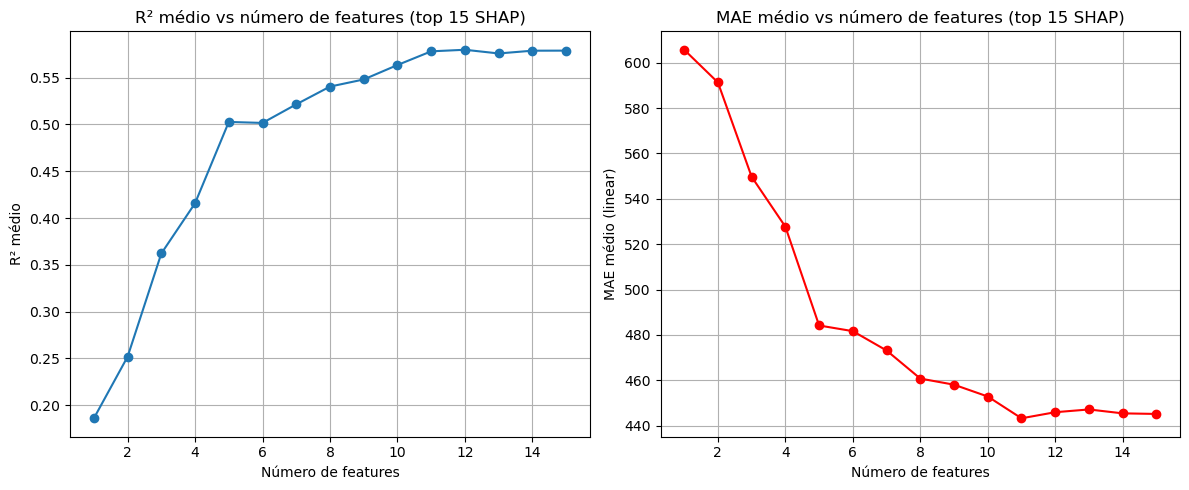

In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import xgboost as xgb

# =============================
# Função inversa do safe log
# =============================
def inverse_safe_log(y_log):
    """Converte valores log transformados de volta para a escala original."""
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

# =============================
# Seleção das top 15 features pelo SHAP
# =============================
top_features = shap_importance['feature'].tolist()[:15]

# Arrays para armazenar métricas
r2_scores = []
mae_scores_linear = []

# RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Loop progressivo adicionando features
for i in range(1, len(top_features)+1):
    selected_features = top_features[:i]
    X_subset = X[selected_features]
    
    r2_list = []
    mae_linear_list = []
    
    # RepeatedKFold
    for train_idx, test_idx in rkf.split(X_subset):
        X_train, X_test = X_subset.iloc[train_idx], X_subset.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Treina modelo com os melhores hiperparâmetros
        model = xgb.XGBRegressor(**best_model.get_params())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Métricas
        r2_list.append(r2_score(y_test, y_pred))
        
        # MAE linear: converter log → linear
        mae_linear_list.append(mean_absolute_error(
            inverse_safe_log(y_test),
            inverse_safe_log(y_pred)
        ))
    
    # Média das métricas
    r2_scores.append(np.mean(r2_list))
    mae_scores_linear.append(np.mean(mae_linear_list))

# =============================
# Plot R² e MAE linear
# =============================
plt.figure(figsize=(12,5))

# R² médio vs número de features
plt.subplot(1,2,1)
plt.plot(range(1, len(top_features)+1), r2_scores, marker='o')
plt.xlabel("Número de features")
plt.ylabel("R² médio")
plt.title("R² médio vs número de features (top 15 SHAP)")
plt.grid(True)

# MAE linear médio vs número de features
plt.subplot(1,2,2)
plt.plot(range(1, len(top_features)+1), mae_scores_linear, marker='o', color='red')
plt.xlabel("Número de features")
plt.ylabel("MAE médio (linear)")
plt.title("MAE médio vs número de features (top 15 SHAP)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# =============================
# Seleção das top N features pelo SHAP
# =============================
n_features = 5
selected_features = shap_importance['feature'].tolist()[:n_features]

X_selected = X[selected_features]
n_samples = len(X_selected)

print(f"Usando as {n_features} features mais importantes: {selected_features}")

# =============================
# RepeatedKFold + média por amostra
# =============================
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)

y_test_sum  = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

r2_list = []
mae_list = []
rmse_list = []

for train_idx, test_idx in rkf.split(X_selected):

    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = xgb.XGBRegressor(**best_model.get_params())
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    y_pred_sum[test_idx] += y_pred
    y_pred_count[test_idx] += 1

    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1

    r2_list.append(r2_score(y_test, y_pred))
    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print("\n=== Desempenho do modelo final (log-transformado) ===")
print(f"R² médio: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
print(f"MAE médio: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE médio: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")

# ============================
# Cálculo das previsões médias por amostra
# ============================
avg_pred_log = y_pred_sum / y_pred_count
avg_actual_log = y_test_sum / y_test_count

print("\n✓ Média de previsões por amostra gerada com sucesso.")

# =============================
# Treinar modelo final
# =============================
final_model_selected = xgb.XGBRegressor(**best_model.get_params())
final_model_selected.fit(X_selected, y)

model_path = f"../../Data/Models/model_xgboost.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_model_selected, f)

print(f"Modelo final salvo como {model_path}")


Usando as 5 features mais importantes: ['duration_p', '3_8y_fir_p', 'f_start', '8_ny_fir_p', 'FWI_12h_av']

=== Desempenho do modelo final (log-transformado) ===
R² médio: 0.4980 ± 0.0460
MAE médio: 0.6045 ± 0.0319
RMSE médio: 0.7677 ± 0.0367

✓ Média de previsões por amostra gerada com sucesso.
Modelo final salvo como ../../Data/Models/model_xgboost.pkl


In [38]:
# ============================================================
# SHAP + PREDIÇÕES MÉDIAS + MERGE COM GEOFILE ORIGINAL
# ============================================================

import numpy as np
import pandas as pd
import geopandas as gpd
import shap
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm

# ------------------------------------------------------------
# 0. Parâmetros
# ------------------------------------------------------------
n_splits = 5
n_repeats = 5
threshold = 35   # 35% erro absoluto
n_features = 5     # top N features
shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
output_base = "../../Data/Models\PT_FireProg_model_SHAP_xgboost"

# df: GeoDataFrame original completo
gdf = gpd.read_file(shp_path).reset_index(drop=True)

# Top N features
selected_features = shap_importance['feature'].tolist()[:n_features]
gdf_valid = gdf.loc[df.index].reset_index(drop=True)  # mantém apenas índices de df
X_selected = gdf_valid[selected_features].copy()
y_selected = y.reset_index(drop=True)

n_samples = len(X_selected)

# DataFrame para armazenar resultados (com os mesmos nomes do segundo script)
shap_results = pd.DataFrame(index=X_selected.index, columns=[
    'ros_p_log','ros_p_linear','PredROS_log','PredROS_linear',
    'PredDiff','Err_pct','Error_p_abs','bad_pred'
])

# SHAP values com os mesmos nomes do segundo script
shap_values_all = pd.DataFrame(index=X_selected.index, columns=[f'{f}' for f in selected_features])

# Vetores para médias
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

# ------------------------------------------------------------
# 1. Repeated CV para previsões médias
# ------------------------------------------------------------
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
print("🔄 Calculando PredROS médias por Repeated CV...")

for train_idx, test_idx in tqdm(rkf.split(X_selected), total=n_splits*n_repeats):
    X_test = X_selected.iloc[test_idx]
    y_test_fold = y_selected.iloc[test_idx]
    
    # Previsão usando modelo final treinado
    y_pred = final_model_selected.predict(X_test)
    
    # Acumular médias
    y_pred_sum[test_idx] += y_pred
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test_fold.values
    y_test_count[test_idx] += 1

# ------------------------------------------------------------
# 2. Médias por amostra
# ------------------------------------------------------------
avg_pred_log = y_pred_sum / y_pred_count
avg_actual_log = y_test_sum / y_test_count

shap_results['PredROS_log'] = avg_pred_log
shap_results['ros_p_log'] = avg_actual_log

# Função inverse log seguro
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

shap_results['PredROS_linear'] = inverse_safe_log(avg_pred_log)
shap_results['ros_p_linear'] = inverse_safe_log(avg_actual_log)

shap_results['PredDiff'] = shap_results['PredROS_linear'] - shap_results['PredROS_linear'].mean()

shap_results['Err_pct'] = ((shap_results['PredROS_linear'] - shap_results['ros_p_linear']) / shap_results['ros_p_linear']) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()
shap_results['bad_pred'] = shap_results['Error_p_abs'] > threshold

# ------------------------------------------------------------
# 3. Calcular SHAP values para top N features
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para top N features...")
explainer = shap.TreeExplainer(final_model_selected)
shap_values = explainer.shap_values(X_selected)
shap_values_df = pd.DataFrame(shap_values, columns=[f'{f}' for f in selected_features], index=X_selected.index)

# Guardar SHAP values
shap_values_all[selected_features] = shap_values_df

# ------------------------------------------------------------
# Renomear colunas duplicadas em shap_results
# ------------------------------------------------------------
dup_cols_results = [col for col in shap_results.columns if col in gdf.columns]
shap_results_renamed = shap_results.rename(columns={col: f"shap_{col}" for col in dup_cols_results})

# ------------------------------------------------------------
# Renomear colunas duplicadas em shap_values_df
# ------------------------------------------------------------
dup_cols_values = [col for col in shap_values_df.columns if col in gdf.columns]
shap_values_renamed = shap_values_df.rename(columns={col: f"shap_{col}" for col in dup_cols_values})

# ------------------------------------------------------------
# Concatenar tudo
# ------------------------------------------------------------
df_with_shap = pd.concat([
    gdf.reset_index(drop=True),
    shap_results_renamed.reset_index(drop=True),
    shap_values_renamed.reset_index(drop=True)
], axis=1)

merged_gdf = gpd.GeoDataFrame(df_with_shap, geometry='geometry', crs=gdf.crs)

# ------------------------------------------------------------
# 6. Salvar CSV e SHP
# ------------------------------------------------------------
output_csv = f"{output_base}.csv"
output_shp = f"{output_base}.shp"

merged_gdf.to_file(output_shp)
merged_gdf.drop(columns='geometry').to_csv(output_csv, index=False)

print(f"\n✅ CSV salvo: {output_csv}")
print(f"✅ SHP salvo: {output_shp}")


🔄 Calculando PredROS médias por Repeated CV...


100%|██████████| 25/25 [00:00<00:00, 781.35it/s]

🔹 Calculando SHAP values para top N features...



C:\Users\dias3\AppData\Local\Temp\ipykernel_17028\117591620.py:129: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file(output_shp)
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'ros_p_linear' to 'ros_p_line'
  ogr_write(
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'PredROS_log' to 'PredROS_lo'
  ogr_write(
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'PredROS_linear' to 'PredROS_li'
  ogr_write(
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Error_p_abs' to 'Error_p_ab'
  ogr_write(
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field nam


✅ CSV salvo: ../../Data/Models\PT_FireProg_model_SHAP_xgboost.csv
✅ SHP salvo: ../../Data/Models\PT_FireProg_model_SHAP_xgboost.shp


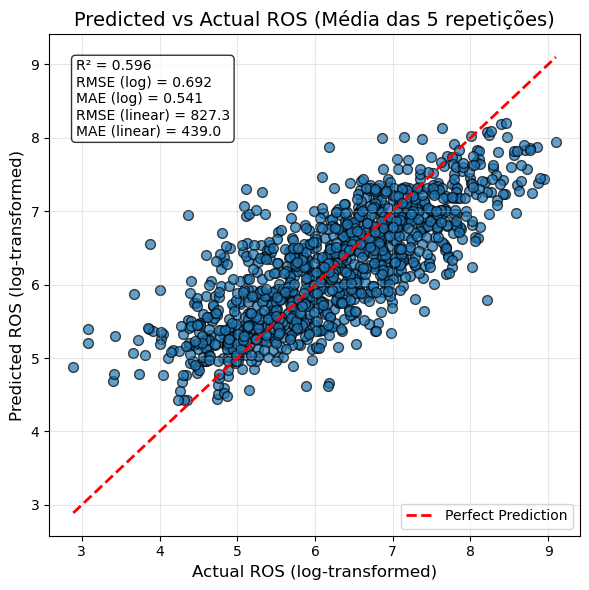

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# =============================
# Usar as médias calculadas na Parte 1
# =============================
y_actual_all = avg_actual_log
y_pred_all = avg_pred_log

# =============================
# Métricas (log e linear)
# =============================
r2_avg = r2_score(y_actual_all, y_pred_all)
mae_log_avg = mean_absolute_error(y_actual_all, y_pred_all)
rmse_log_avg = np.sqrt(mean_squared_error(y_actual_all, y_pred_all))

def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

y_actual_linear = inverse_safe_log(y_actual_all)
y_pred_linear = inverse_safe_log(y_pred_all)

mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))

# =============================
# Scatter Plot com valores médios
# =============================
plt.figure(figsize=(6, 6))
plt.scatter(y_actual_all, y_pred_all, alpha=0.7, edgecolor='k', s=50)

min_val = min(y_actual_all.min(), y_pred_all.min())
max_val = max(y_actual_all.max(), y_pred_all.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Média das 5 repetições)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f'R² = {r2_avg:.3f}\n'
    f'RMSE (log) = {rmse_log_avg:.3f}\n'
    f'MAE (log) = {mae_log_avg:.3f}\n'
    f'RMSE (linear) = {rmse_linear_avg:.1f}\n'
    f'MAE (linear) = {mae_linear_avg:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


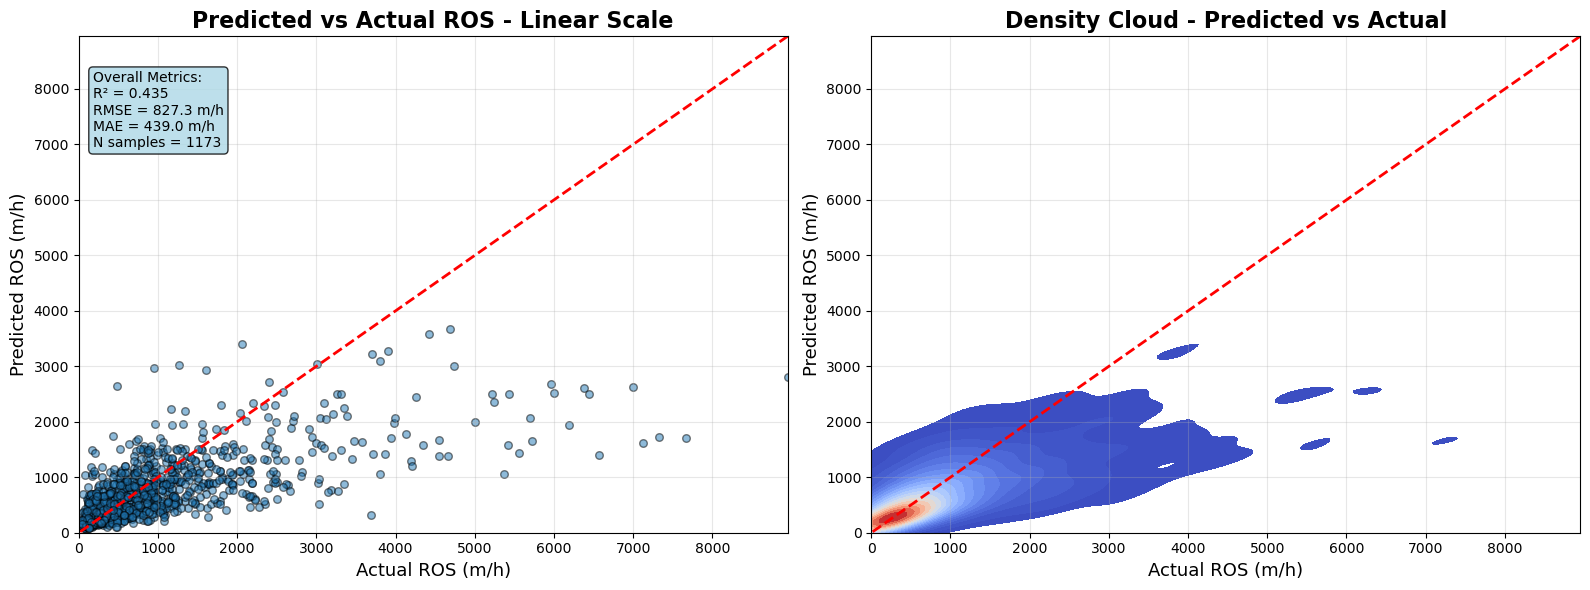

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# =============================
# Usar valores MÉDIOS já calculados no RepeatedKFold
# =============================
y_actual_log = avg_actual_log       # vindo da Parte 1
y_pred_log = avg_pred_log           # vindo da Parte 1

# Converter de log → linear
y_actual_linear = inverse_safe_log(y_actual_log)
y_pred_linear = inverse_safe_log(y_pred_log)

# =============================
# Métricas lineares
# =============================
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)
r2_linear = r2_score(y_actual_linear, y_pred_linear)

# =============================
# Plots: Scatter + 2D KDE
# =============================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# =============================
# Left panel: Scatter plot
# =============================
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

metrics_text = (
    f'Overall Metrics:\n'
    f'R² = {r2_linear:.3f}\n'
    f'RMSE = {rmse_linear_avg:.1f} m/h\n'
    f'MAE = {mae_linear_avg:.1f} m/h\n'
    f'N samples = {len(y_actual_linear)}'
)
ax1.text(
    0.02, 0.93, metrics_text,
    transform=ax1.transAxes, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10
)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# =============================
# Right panel: 2D KDE density plot
# =============================
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


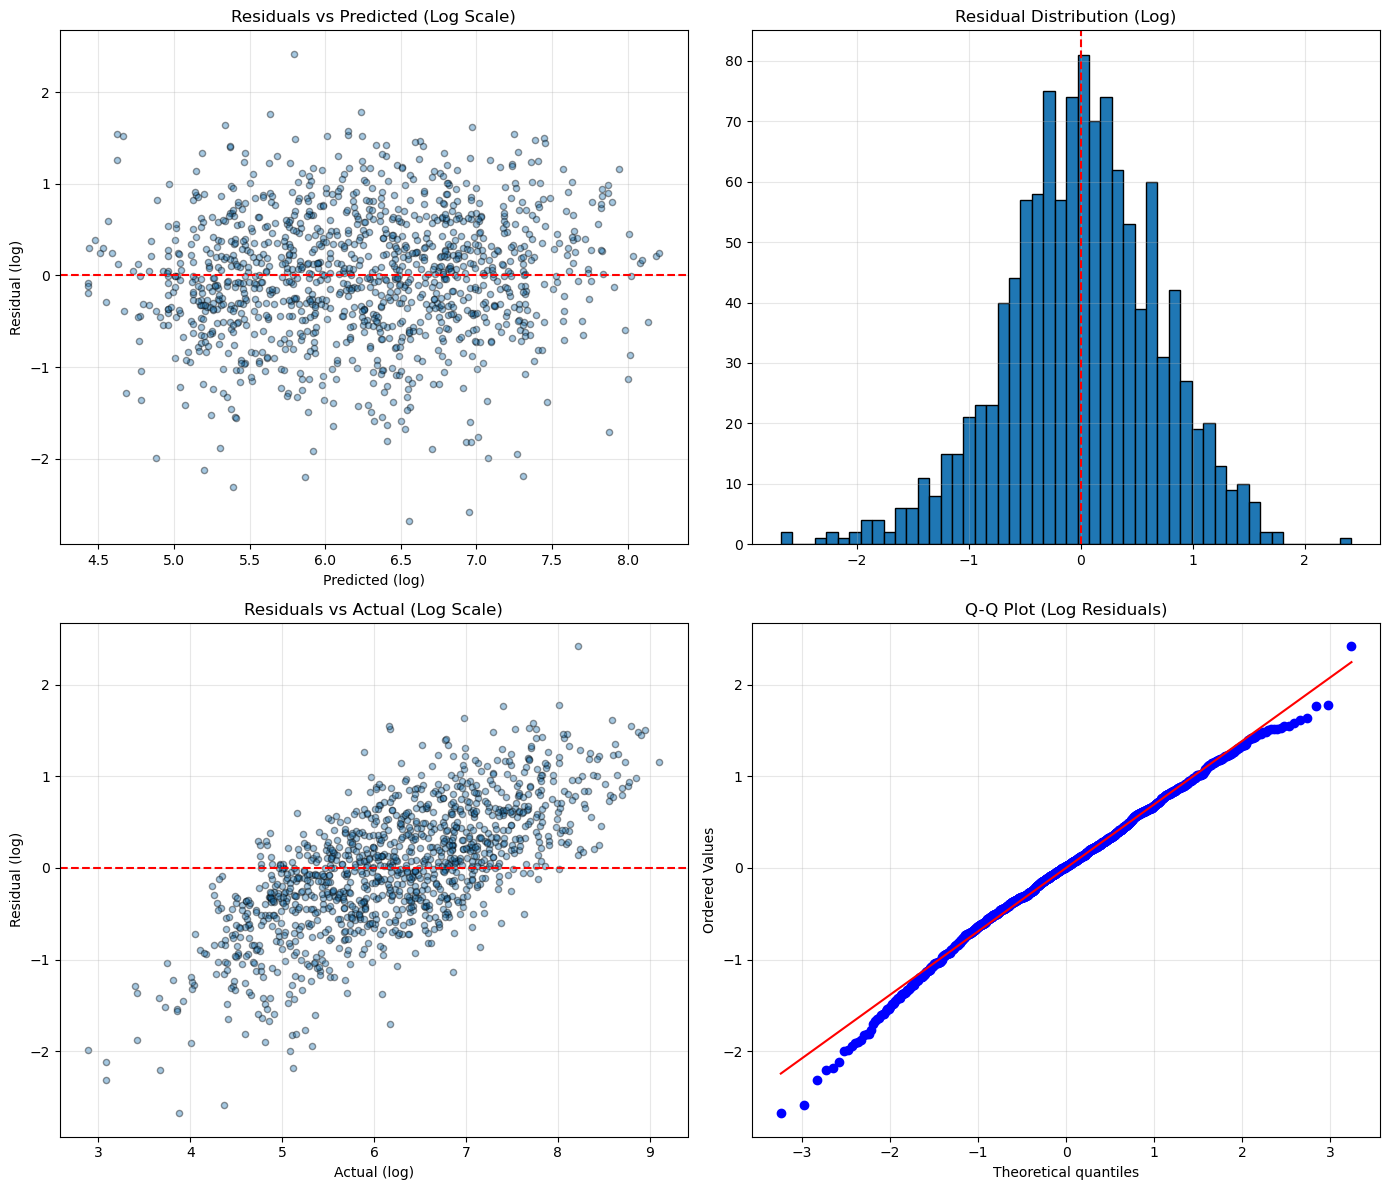

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Usar diretamente as MÉDIAS do RepeatedKFold
# =============================
avg_actual = avg_actual_log      # valores reais médios (log)
avg_pred   = avg_pred_log        # valores previstos médios (log)

# Conversão para escala linear (se quiser usar depois)
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos em escala log
residuals_log = avg_actual - avg_pred

# =============================
# RESIDUAL PLOTS
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram of residuals
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q Plot
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


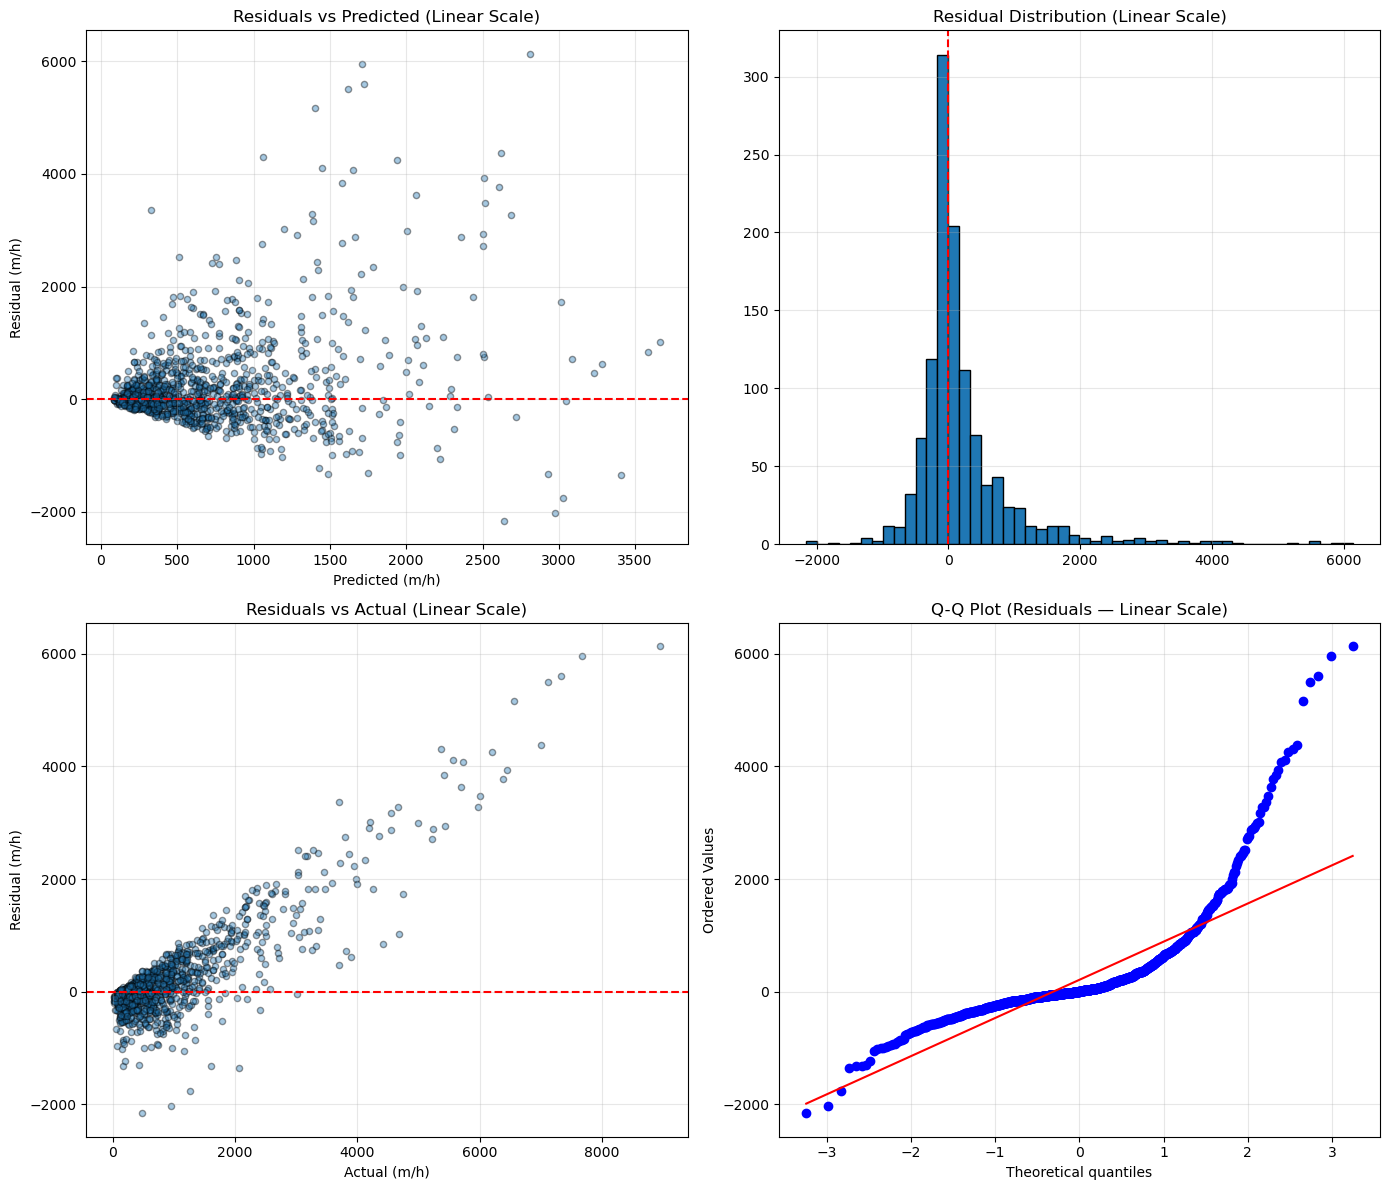

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = avg_actual_log      # já calculado antes
avg_pred_log   = avg_pred_log        # já calculado antes

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 486  (41.4%)
Bad Predictions  : 687  (58.6%)


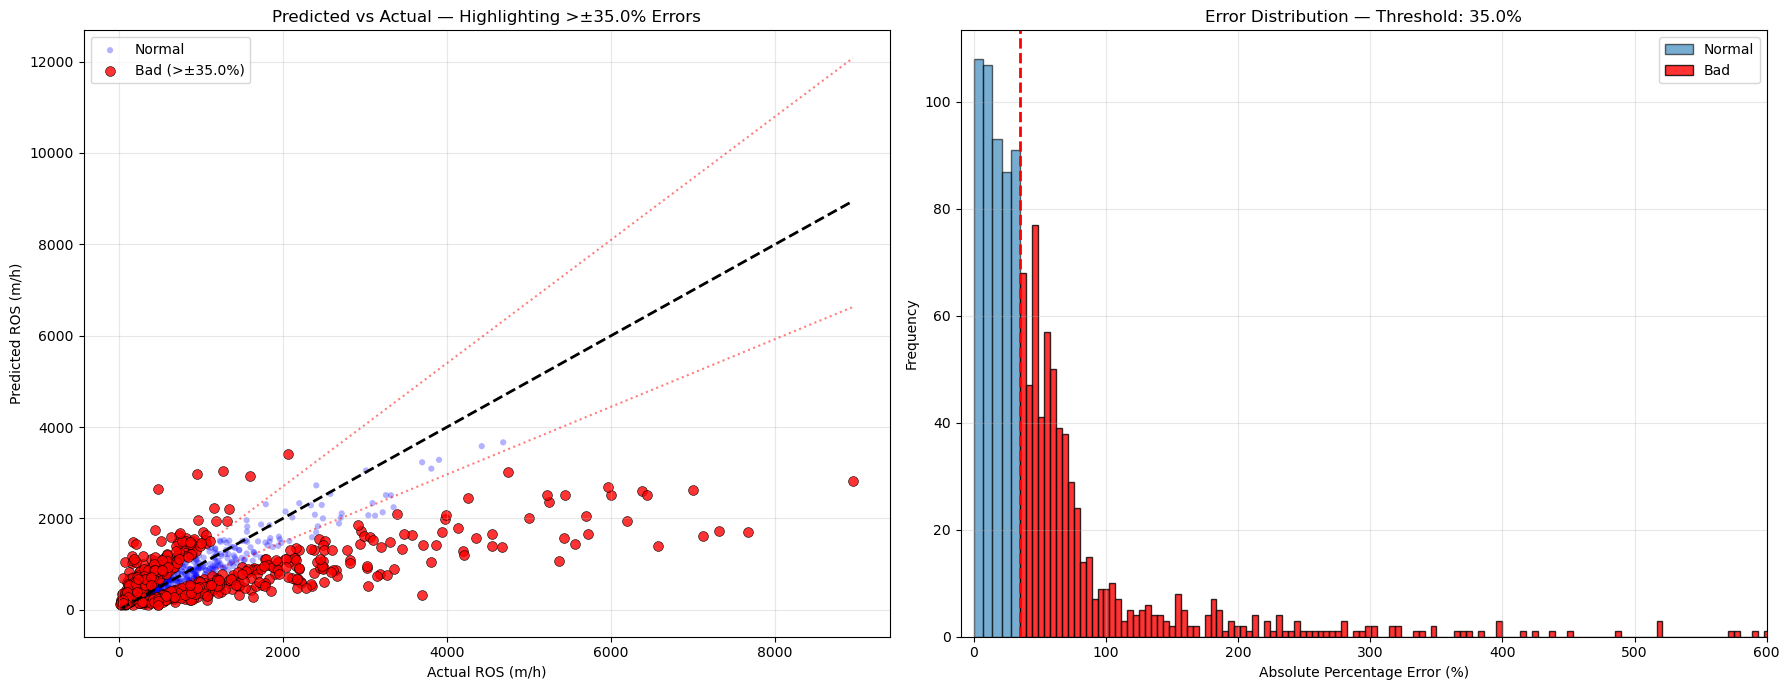

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()


# **ACABOU AQUI**

In [ ]:
from sklearn.model_selection import RepeatedKFold
from collections import defaultdict

rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=42)

fold_results = []
predictions_by_idx = defaultdict(list)
actuals_by_idx = {}

param_dist = {
    'max_depth': [3, 4, 5],
    'learning_rate': uniform(0.05, 0.20),
    'subsample': uniform(0.55, 0.25),
    'colsample_bytree': uniform(0.55, 0.25),
    'colsample_bylevel': uniform(0.55, 0.25),
    'colsample_bynode': uniform(0.55, 0.25),
    'min_child_weight': randint(30, 80),
    'gamma': uniform(1.5, 2.5),
    'reg_alpha': uniform(1.0, 2.5),
    'reg_lambda': uniform(3, 4),
    'max_delta_step': randint(0, 5),
}

for fold, (train_idx, test_idx) in enumerate(rkf.split(X)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/20")
    print(f"{'='*50}")
    
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    y_train_log = log_mult * np.log1p(y_train) / np.log(log_base)
    y_test_log = log_mult * np.log1p(y_test) / np.log(log_base)
    
    base_model = xgb.XGBRegressor(
        n_jobs=-1,
        random_state=42,
        objective='reg:squarederror',
        tree_method='hist',
        enable_categorical=True
    )
    
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    xgb_search = HalvingRandomSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        factor=3,
        resource='n_estimators',
        max_resources=250,
        min_resources=25,
        scoring='r2',
        cv=inner_cv,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    xgb_search.fit(X_train, y_train_log)
    model = xgb_search.best_estimator_
    
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    # Store predictions by original index
    for idx, pred, actual in zip(test_idx, y_test_pred_log, y_test_log.values):
        predictions_by_idx[idx].append(pred)
        actuals_by_idx[idx] = actual
    
    r2_train = r2_score(y_train_log, y_train_pred_log)
    r2_test = r2_score(y_test_log, y_test_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test_log, y_test_pred_log))
    mae_log = mean_absolute_error(y_test_log, y_test_pred_log)
    
    y_test_linear = np.exp(y_test_log * inv_mult) - 1
    y_test_pred_linear = np.exp(y_test_pred_log * inv_mult) - 1
    rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_test_pred_linear))
    mae_linear = mean_absolute_error(y_test_linear, y_test_pred_linear)
    
    fold_results.append({
        'fold': fold + 1,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'rmse_linear': rmse_linear,
        'mae_linear': mae_linear,
        'best_params': xgb_search.best_params_,
        'model': model
    })
    
    print(f"Train R²: {r2_train:.4f} | Test R²: {r2_test:.4f} | Gap: {r2_train - r2_test:.4f}")

results_df = pd.DataFrame(fold_results)

print("\n" + "="*60)
print("AVERAGED RESULTS ACROSS 20 FOLDS")
print("="*60)
print(f"Mean Train R² (log):    {results_df['r2_train'].mean():.4f} ± {results_df['r2_train'].std():.4f}")
print(f"Mean Test R² (log):     {results_df['r2_test'].mean():.4f} ± {results_df['r2_test'].std():.4f}")
print(f"Mean Overfitting Gap:   {(results_df['r2_train'] - results_df['r2_test']).mean():.4f}")
print(f"Mean RMSE (log):        {results_df['rmse_log'].mean():.4f} ± {results_df['rmse_log'].std():.4f}")
print(f"Mean MAE (log):         {results_df['mae_log'].mean():.4f} ± {results_df['mae_log'].std():.4f}")
print(f"Mean RMSE (linear):     {results_df['rmse_linear'].mean():.1f} ± {results_df['rmse_linear'].std():.1f}")
print(f"Mean MAE (linear):      {results_df['mae_linear'].mean():.1f} ± {results_df['mae_linear'].std():.1f}")

# Average predictions per data point
indices = sorted(predictions_by_idx.keys())
avg_pred = np.array([np.mean(predictions_by_idx[i]) for i in indices])
avg_actual = np.array([actuals_by_idx[i] for i in indices])

# Aggregated metrics
r2_avg = r2_score(avg_actual, avg_pred)
rmse_log_avg = np.sqrt(mean_squared_error(avg_actual, avg_pred))
mae_log_avg = mean_absolute_error(avg_actual, avg_pred)

avg_actual_linear = np.exp(avg_actual * inv_mult) - 1
avg_pred_linear = np.exp(avg_pred * inv_mult) - 1
rmse_linear_avg = np.sqrt(mean_squared_error(avg_actual_linear, avg_pred_linear))
mae_linear_avg = mean_absolute_error(avg_actual_linear, avg_pred_linear)

# Plot 1: R² distribution across folds
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(results_df['fold'], results_df['r2_test'], alpha=0.7, label='Test R²')
axes[0].axhline(results_df['r2_test'].mean(), color='r', linestyle='--', label=f"Mean: {results_df['r2_test'].mean():.3f}")
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Test R² Across 20 Folds')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot([results_df['r2_train'], results_df['r2_test']], labels=['Train R²', 'Test R²'])
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Predicted vs Actual scatter plot (averaged)
plt.figure(figsize=(6, 6))
plt.scatter(avg_actual, avg_pred, alpha=0.5, edgecolor='k', s=40)

min_val = min(avg_actual.min(), avg_pred.min())
max_val = max(avg_actual.max(), avg_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Nested CV: Predicted vs Actual Fire Spread Rate - XGBoost', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(0.05, 0.95, 
    f'R² = {r2_avg:.3f}\n'
    f'RMSE (log) = {rmse_log_avg:.3f}\n'
    f'MAE (log) = {mae_log_avg:.3f}\n'
    f'RMSE (linear) = {rmse_linear_avg:.1f}\n'
    f'MAE (linear) = {mae_linear_avg:.1f}', 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

def tick_formatter_log_to_linear(x, pos):
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


FOLD 1/20


NameError: name 'log_mult' is not defined


METRICS BY ROS CLASS (Linear Space) - Minimum 5 observations per class
Class             N  Mean Actual       RMSE        MAE     RMSE %      MAE %
--------------------------------------------------------------------------------
0-100           308         72.0      279.5      162.8     388.2%     226.1%
100-200         716        147.2      283.6      164.7     192.6%     111.8%
200-300         516        249.0      263.2      172.2     105.7%      69.1%
300-400         416        348.6      241.4      175.8      69.2%      50.4%
400-500         332        445.7      324.6      219.1      72.8%      49.2%
500-600         280        550.8      351.0      267.4      63.7%      48.6%
600-700         244        646.8      353.4      285.1      54.6%      44.1%
700-800         168        742.4      501.9      384.8      67.6%      51.8%
800-900         196        851.5      410.5      347.3      48.2%      40.8%
900-1000        204        946.9      505.7      381.8      53.4%      40.3%


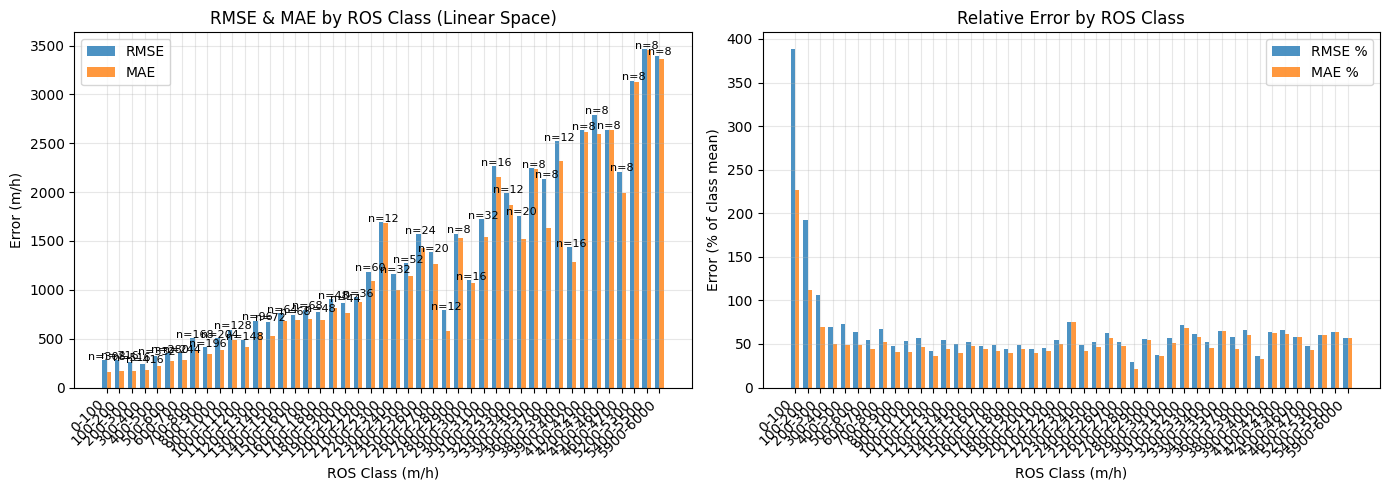


Class metrics saved to class_metrics.csv


In [ ]:
# Collect all test predictions across folds
all_y_test_linear = []
all_y_pred_linear = []

for fold, (train_idx, test_idx) in enumerate(rkf.split(X)):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    
    # Get the trained model for this fold
    model = fold_results[fold]['model']
    
    # Log transform and predict
    y_test_log = log_mult * np.log1p(y_test) / np.log(log_base)
    y_test_pred_log = model.predict(X_test)
    
    # Convert to linear space
    y_test_linear = np.exp(y_test_log * inv_mult) - 1
    y_test_pred_linear = np.exp(y_test_pred_log * inv_mult) - 1
    
    all_y_test_linear.extend(y_test_linear.values)
    all_y_pred_linear.extend(y_test_pred_linear)

all_y_test_linear = np.array(all_y_test_linear)
all_y_pred_linear = np.array(all_y_pred_linear)

# Create bins of 100
max_val = int(np.ceil(all_y_test_linear.max() / 100) * 100)
bins = np.arange(0, max_val + 100, 100)
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

# Assign each observation to a bin
bin_indices = np.digitize(all_y_test_linear, bins) - 1
bin_indices = np.clip(bin_indices, 0, len(bin_labels) - 1)

# Calculate metrics per class
class_metrics = []

for i, label in enumerate(bin_labels):
    mask = bin_indices == i
    n_obs = mask.sum()
    
    if n_obs >= 5:
        y_true = all_y_test_linear[mask]
        y_pred = all_y_pred_linear[mask]
        
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        mean_actual = y_true.mean()
        
        class_metrics.append({
            'class': label,
            'n_obs': n_obs,
            'mean_actual': mean_actual,
            'rmse_linear': rmse,
            'mae_linear': mae,
            'rmse_pct': (rmse / mean_actual) * 100,  # RMSE as % of mean
            'mae_pct': (mae / mean_actual) * 100     # MAE as % of mean
        })

class_df = pd.DataFrame(class_metrics)

# Display table
print("\n" + "="*80)
print("METRICS BY ROS CLASS (Linear Space) - Minimum 5 observations per class")
print("="*80)
print(f"{'Class':<12} {'N':>6} {'Mean Actual':>12} {'RMSE':>10} {'MAE':>10} {'RMSE %':>10} {'MAE %':>10}")
print("-"*80)

for _, row in class_df.iterrows():
    print(f"{row['class']:<12} {row['n_obs']:>6} {row['mean_actual']:>12.1f} {row['rmse_linear']:>10.1f} {row['mae_linear']:>10.1f} {row['rmse_pct']:>9.1f}% {row['mae_pct']:>9.1f}%")

print("-"*80)
print(f"{'OVERALL':<12} {len(all_y_test_linear):>6} {all_y_test_linear.mean():>12.1f} {np.sqrt(mean_squared_error(all_y_test_linear, all_y_pred_linear)):>10.1f} {mean_absolute_error(all_y_test_linear, all_y_pred_linear):>10.1f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(class_df))
width = 0.35

# RMSE and MAE by class
axes[0].bar(x_pos - width/2, class_df['rmse_linear'], width, label='RMSE', alpha=0.8)
axes[0].bar(x_pos + width/2, class_df['mae_linear'], width, label='MAE', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(class_df['class'], rotation=45, ha='right')
axes[0].set_xlabel('ROS Class (m/h)')
axes[0].set_ylabel('Error (m/h)')
axes[0].set_title('RMSE & MAE by ROS Class (Linear Space)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add observation counts on top
for i, n in enumerate(class_df['n_obs']):
    axes[0].annotate(f'n={n}', (i, max(class_df.loc[i, 'rmse_linear'], class_df.loc[i, 'mae_linear']) + 5),
                     ha='center', fontsize=8)

# Percentage errors by class
axes[1].bar(x_pos - width/2, class_df['rmse_pct'], width, label='RMSE %', alpha=0.8)
axes[1].bar(x_pos + width/2, class_df['mae_pct'], width, label='MAE %', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(class_df['class'], rotation=45, ha='right')
axes[1].set_xlabel('ROS Class (m/h)')
axes[1].set_ylabel('Error (% of class mean)')
axes[1].set_title('Relative Error by ROS Class')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save class metrics
class_df.to_csv("../../Data/Models/class_metrics.csv", index=False)
print("\nClass metrics saved to class_metrics.csv")

NOTE: The saved model will make predictions in Log space since it was trained in that space. To see outputs in linear space, a conversion needs to be perfomed after running the model. The code below stores the Log transformation applied so that it can be reversed in the future.

In [ ]:
import json
transform_params = {
    'log_mult': log_mult, 
    'log_base': log_base,
    'inverse_formula': 'y_val_log = np.exp(y_val_pred_log * np.log(log_base) / log_mult) - 1'
}
with open('../../Data/Models/XGBoost_transform_param.json', 'w') as f:
    json.dump(transform_params, f)

This file would then be used as follows:
```python
# Load the model
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("../../Data/Models/XGBoost.json")

# Load the transformation parameters
with open('../../Data/Models/XGBoost_transform.json', 'r') as f:
    transform_params = json.load(f)

# Make predictions in log space
y_val_pred_log = loaded_model.predict(X_new)

# Inverse transform using the saved parameters
log_mult = transform_params['log_mult']
log_base = transform_params['log_base']

y_val_pred_log = np.exp(y_val_pred_log * np.log(log_base) / log_mult) - 1
```

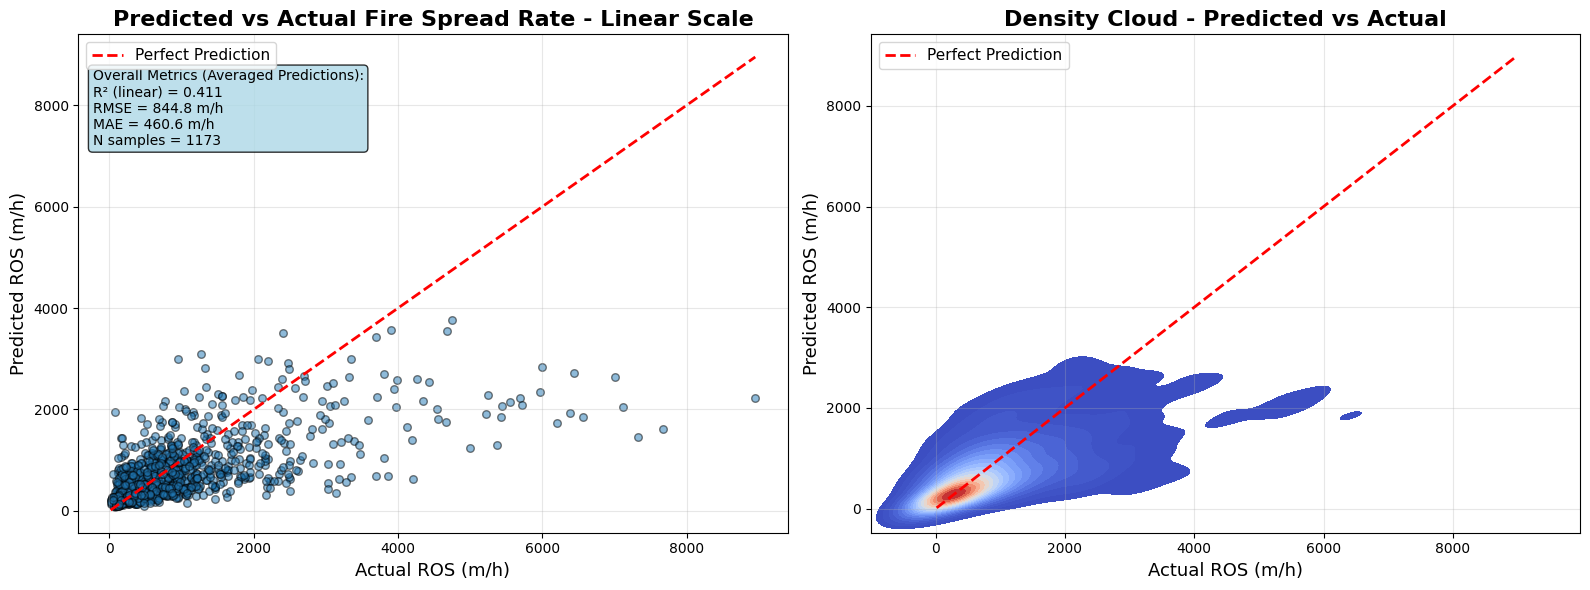

In [ ]:
"""
The same plot as above but in linear scale with 2D KDE density plot
"""

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

# Left panel: Scatter plot
ax1.scatter(avg_actual_linear, avg_pred_linear, alpha=0.5, edgecolor='k', s=30)

min_val_linear = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val_linear = max(avg_actual_linear.max(), avg_pred_linear.max())
ax1.plot([min_val_linear, max_val_linear], [min_val_linear, max_val_linear], 'r--', linewidth=2, label='Perfect Prediction')

ax1.set_title('Predicted vs Actual Fire Spread Rate - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

metrics_text = (
    f'Overall Metrics (Averaged Predictions):\n'
    f'R² (linear) = {r2_score(avg_actual_linear, avg_pred_linear):.3f}\n'
    f'RMSE = {rmse_linear_avg:.1f} m/h\n'
    f'MAE = {mae_linear_avg:.1f} m/h\n'
    f'N samples = {len(avg_actual_linear)}'
)
ax1.text(0.02, 0.93, 
    metrics_text, 
    transform=ax1.transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10)

ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Right panel: 2D KDE density plot
sns.kdeplot(x=avg_actual_linear, y=avg_pred_linear, 
            ax=ax2, fill=True, cmap="coolwarm", 
            levels=20, thresh=0.04)
ax2.plot([min_val_linear, max_val_linear], [min_val_linear, max_val_linear], 
         'r--', linewidth=2, label='Perfect Prediction')

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
"""import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
from collections import defaultdict

# Features in importance order (top = most important)
features = [
    "duration_p",
    "wv100_k_av",
    "8_ny_fir_p",
    "3_8y_fir_p",
    "f_load_av",
    "f_start",
    "FWI_12h_av",
    "HDW_av",
    "dfmc_av",
    "sW_100_av",
    "gT_8_7_av",
    "gT_s_9_av",
    "wSv_1_av",
    "sW_28_av",
    "Cape_av",
    "aspect_av",
    "landform",
    "sW_1m_av",
    "LiftIdx_av",
    "1_3y_fir_p"
]

ranked_features = features.copy()

# Hyperparameter search setup
param_dist = {
    'max_depth': [3, 4, 5],
    'learning_rate': uniform(0.05, 0.20),
    'subsample': uniform(0.55, 0.25),
    'colsample_bytree': uniform(0.55, 0.25),
    'colsample_bylevel': uniform(0.55, 0.25),
    'colsample_bynode': uniform(0.55, 0.25),
    'min_child_weight': randint(30, 80),
    'gamma': uniform(1.5, 2.5),
    'reg_alpha': uniform(1.0, 2.5),
    'reg_lambda': uniform(3, 4),
    'max_delta_step': randint(0, 5),
}

base_model = xgb.XGBRegressor(
    n_jobs=-1,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True
)

# Progressive feature reduction
feature_counts = list(range(len(features), 0, -1))  # 20, 19, 18, ..., 1
results = {
    'n_features': [],
    'r2_train_mean': [],
    'r2_train_std': [],
    'r2_test_mean': [],
    'r2_test_std': [],
    'rmse_log_mean': [],
    'rmse_log_std': [],
    'rmse_linear_mean': [],
    'features_used': []
}

print("=" * 60)
print("PROGRESSIVE FEATURE REDUCTION ANALYSIS (Nested CV)")
print("=" * 60)

for n_feat in feature_counts:
    current_features = ranked_features[:n_feat]
    
    print(f"\n{'='*50}")
    print(f"Training with {n_feat} features...")
    print(f"{'='*50}")
    
    # Nested CV setup
    rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=42)
    
    fold_r2_train = []
    fold_r2_test = []
    fold_rmse_log = []
    fold_rmse_linear = []
    
    for fold, (train_idx, test_idx) in enumerate(rkf.split(X)):
        X_train_fold = X.iloc[train_idx][current_features]
        X_test_fold = X.iloc[test_idx][current_features]
        y_train_fold = y.iloc[train_idx]
        y_test_fold = y.iloc[test_idx]
        
        # Log transform
        y_train_log = log_mult * np.log1p(y_train_fold) / np.log(log_base)
        y_test_log = log_mult * np.log1p(y_test_fold) / np.log(log_base)
        
        # Inner CV for hyperparameter tuning
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        
        xgb_search = HalvingRandomSearchCV(
            estimator=base_model,
            param_distributions=param_dist,
            factor=3,
            resource='n_estimators',
            max_resources=250,
            min_resources=25,
            scoring='r2',
            cv=inner_cv,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        xgb_search.fit(X_train_fold, y_train_log)
        model = xgb_search.best_estimator_
        
        # Predictions
        y_train_pred_log = model.predict(X_train_fold)
        y_test_pred_log = model.predict(X_test_fold)
        
        # Metrics
        r2_train = r2_score(y_train_log, y_train_pred_log)
        r2_test = r2_score(y_test_log, y_test_pred_log)
        rmse_log = np.sqrt(mean_squared_error(y_test_log, y_test_pred_log))
        
        # Linear space RMSE
        y_test_pred_linear = np.exp(y_test_pred_log * inv_mult) - 1
        y_test_linear = np.exp(y_test_log * inv_mult) - 1
        rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_test_pred_linear))
        
        fold_r2_train.append(r2_train)
        fold_r2_test.append(r2_test)
        fold_rmse_log.append(rmse_log)
        fold_rmse_linear.append(rmse_linear)
    
    # Store averaged results
    results['n_features'].append(n_feat)
    results['r2_train_mean'].append(np.mean(fold_r2_train))
    results['r2_train_std'].append(np.std(fold_r2_train))
    results['r2_test_mean'].append(np.mean(fold_r2_test))
    results['r2_test_std'].append(np.std(fold_r2_test))
    results['rmse_log_mean'].append(np.mean(fold_rmse_log))
    results['rmse_log_std'].append(np.std(fold_rmse_log))
    results['rmse_linear_mean'].append(np.mean(fold_rmse_linear))
    results['features_used'].append(current_features)
    
    print(f"  R² Train: {np.mean(fold_r2_train):.4f} ± {np.std(fold_r2_train):.4f}")
    print(f"  R² Test:  {np.mean(fold_r2_test):.4f} ± {np.std(fold_r2_test):.4f}")
    print(f"  RMSE (log): {np.mean(fold_rmse_log):.4f} ± {np.std(fold_rmse_log):.4f}")

# --- Plot results ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# R² on left y-axis with error bands
color_r2 = 'tab:blue'
ax1.set_xlabel('Number of Features', fontsize=12)
ax1.set_ylabel('R² Score', color=color_r2, fontsize=12)

r2_test_mean = np.array(results['r2_test_mean'])
r2_test_std = np.array(results['r2_test_std'])
r2_train_mean = np.array(results['r2_train_mean'])

ax1.plot(results['n_features'], r2_test_mean, 'o-', color=color_r2, 
         label='Test R² (mean)', linewidth=2, markersize=6)
ax1.fill_between(results['n_features'], r2_test_mean - r2_test_std, r2_test_mean + r2_test_std,
                 color=color_r2, alpha=0.2)
ax1.plot(results['n_features'], r2_train_mean, 's--', color='lightblue',
         label='Train R² (mean)', linewidth=1.5, markersize=5, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color_r2)
ax1.set_xlim(min(results['n_features']) - 0.5, max(results['n_features']) + 0.5)

# RMSE on right y-axis
ax2 = ax1.twinx()
color_rmse = 'tab:red'
ax2.set_ylabel('RMSE (log-transformed)', color=color_rmse, fontsize=12)

rmse_mean = np.array(results['rmse_log_mean'])
rmse_std = np.array(results['rmse_log_std'])

ax2.plot(results['n_features'], rmse_mean, '^-', color=color_rmse,
         label='Test RMSE (mean)', linewidth=2, markersize=6)
ax2.fill_between(results['n_features'], rmse_mean - rmse_std, rmse_mean + rmse_std,
                 color=color_rmse, alpha=0.2)
ax2.tick_params(axis='y', labelcolor=color_rmse)

# Find optimal point (best test R²)
best_idx = np.argmax(results['r2_test_mean'])
best_n = results['n_features'][best_idx]
best_r2 = results['r2_test_mean'][best_idx]
best_r2_std = results['r2_test_std'][best_idx]
best_rmse = results['rmse_log_mean'][best_idx]

ax1.axvline(x=best_n, color='green', linestyle=':', alpha=0.7, linewidth=2)
ax1.annotate(f'Optimal: {best_n} features\nR²={best_r2:.4f}±{best_r2_std:.4f}\nRMSE={best_rmse:.4f}',
             xy=(best_n, best_r2), xytext=(best_n + 2, best_r2 - 0.05),
             fontsize=10, ha='left',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             arrowprops=dict(arrowstyle='->', color='green'))

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

plt.title('Progressive Feature Reduction: R² and RMSE vs Number of Features\n(20-fold Nested CV)', fontsize=14)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Summary ---
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Optimal number of features: {best_n}")
print(f"Best test R²: {best_r2:.4f} ± {best_r2_std:.4f}")
print(f"Best test RMSE (log): {best_rmse:.4f}")
print(f"\nOptimal feature set:")
for i, feat in enumerate(results['features_used'][best_idx], 1):
    print(f"  {i}. {feat}")"""

'import numpy as np\nimport xgboost as xgb\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import KFold, RepeatedKFold\nfrom sklearn.experimental import enable_halving_search_cv\nfrom sklearn.model_selection import HalvingRandomSearchCV\nfrom sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error\nfrom scipy.stats import uniform, randint\nfrom collections import defaultdict\n\n# Features in importance order (top = most important)\nfeatures = [\n    "duration_p",\n    "wv100_k_av",\n    "8_ny_fir_p",\n    "3_8y_fir_p",\n    "f_load_av",\n    "f_start",\n    "FWI_12h_av",\n    "HDW_av",\n    "dfmc_av",\n    "sW_100_av",\n    "gT_8_7_av",\n    "gT_s_9_av",\n    "wSv_1_av",\n    "sW_28_av",\n    "Cape_av",\n    "aspect_av",\n    "landform",\n    "sW_1m_av",\n    "LiftIdx_av",\n    "1_3y_fir_p"\n]\n\nranked_features = features.copy()\n\n# Hyperparameter search setup\nparam_dist = {\n    \'max_depth\': [3, 4, 5],\n    \'learning_rate\': uniform(0.05, 0.20),\n

### Residuals analysis in log and linear scales


RESIDUAL ANALYSIS

RESIDUAL STATISTICS (Log Scale):
Mean Residual:        -0.0023
Median Residual:      0.0114
Std Dev Residual:     1.5894
Min Residual:         -6.9537
Max Residual:         4.7888

RESIDUAL STATISTICS (Linear Scale):
Mean Residual:        198.63 m/h
Median Residual:      3.22 m/h
Std Dev Residual:     821.10 m/h
Min Residual:         -2039.30 m/h
Max Residual:         6729.04 m/h

Predictions within ±0.5 (log):   26.6%
Predictions within ±1.0 (log):   48.9%
Predictions within ±2.0 (log):   79.9%

Predictions within ±10 m/h:   2.9%
Predictions within ±50 m/h:   15.8%
Predictions within ±100 m/h:  28.0%

------------------------------------------------------------
SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LOG SCALE):
------------------------------------------------------------

Range (log)     Count      Mean Error      RMSE           
------------------------------------------------------------
8-10            7             +0.4784           1.3884
10+    

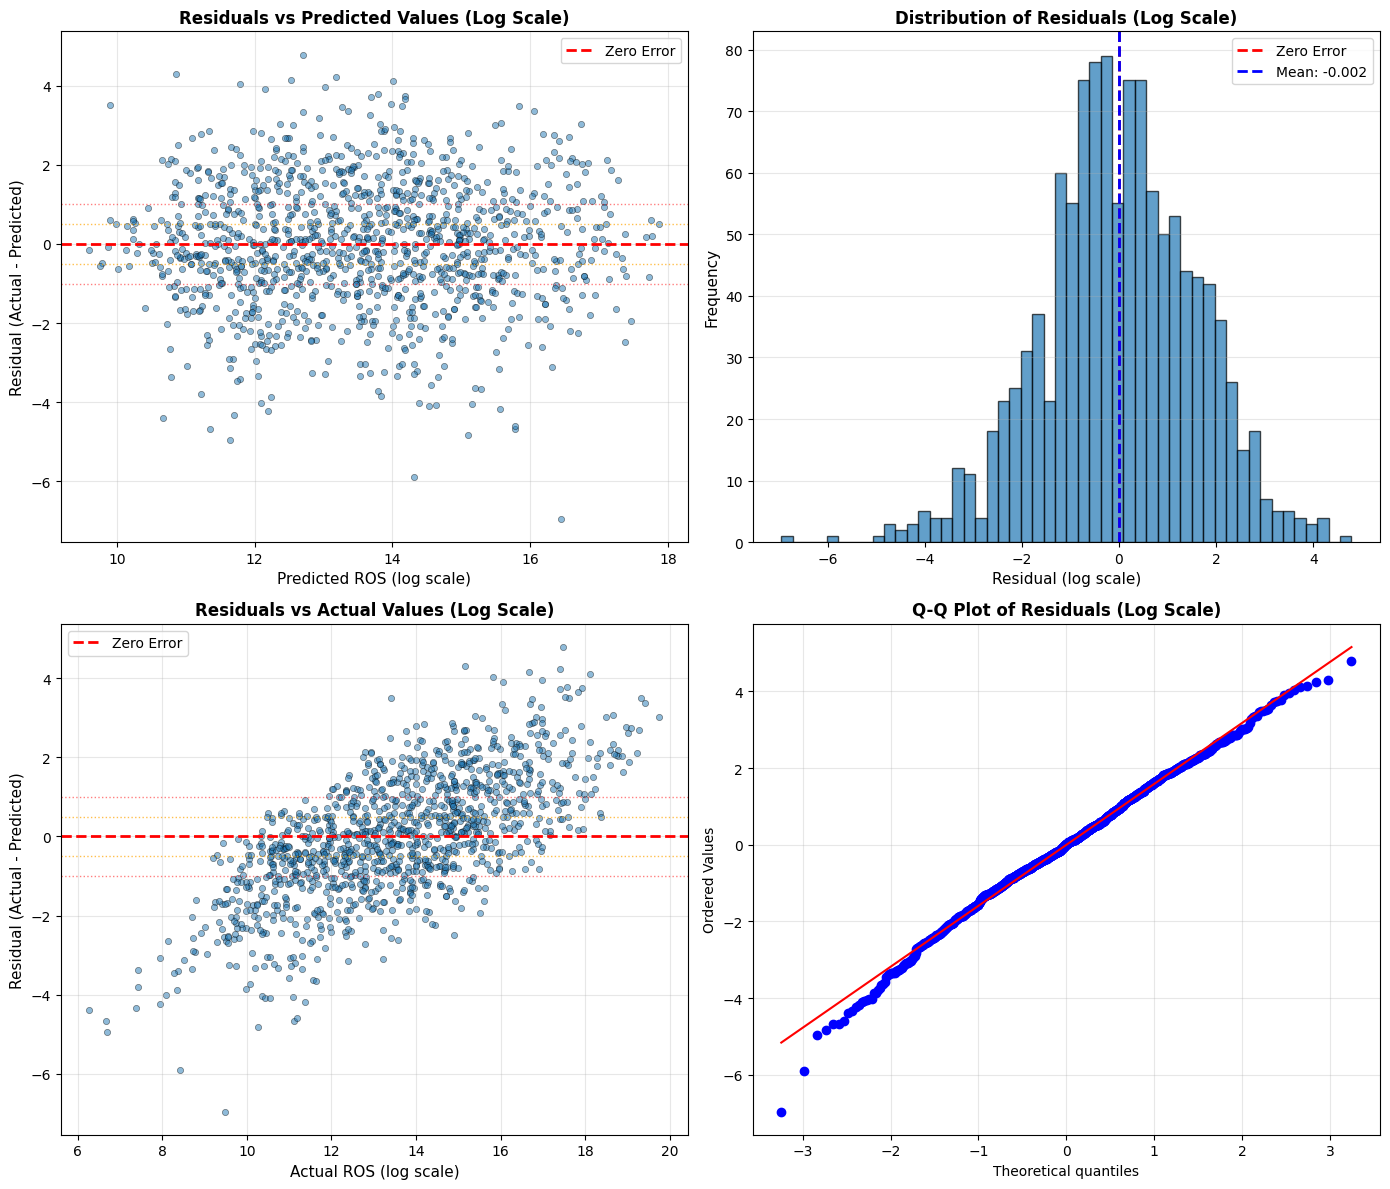


Residuals Plots (Linear Scale)


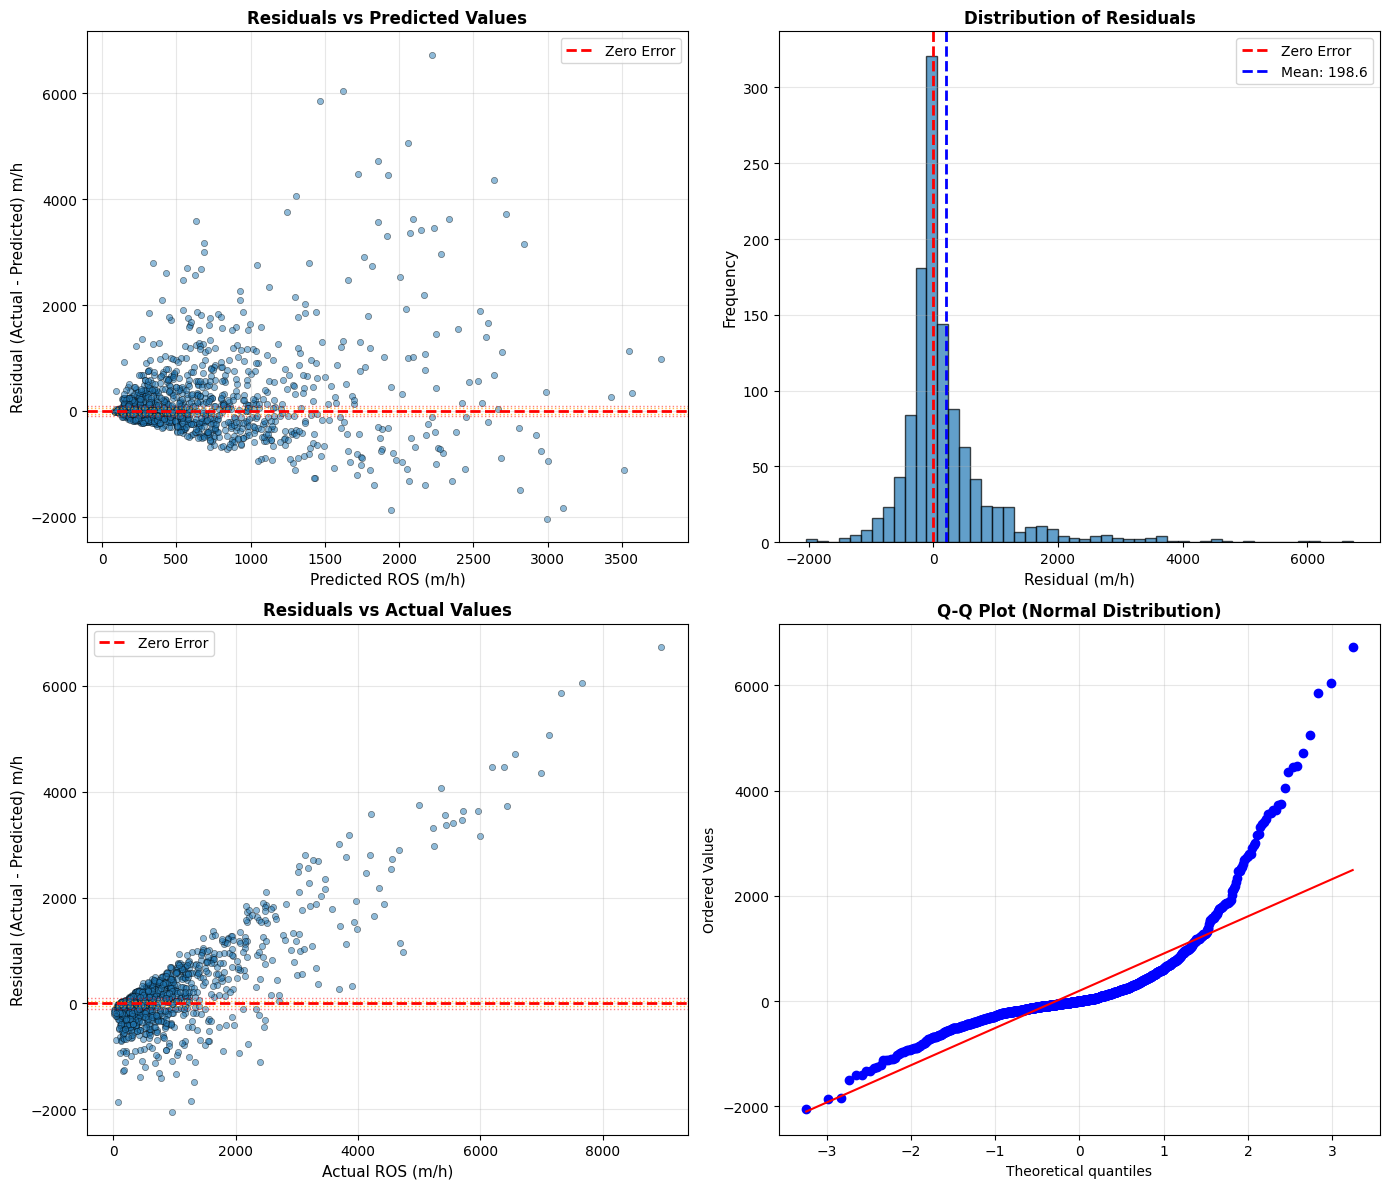


PERCENTAGE ERROR ANALYSIS (for actual ROS > 1 m/h):
Mean Percentage Error:    -34.21%
Median Percentage Error:  +0.52%
Std Dev Percentage Error: 141.04%

SYSTEMATIC BIAS DETECTED: Model tends to UNDERPREDICT by 198.6 m/h on average


In [ ]:
print("\n" + "="*60)
print("RESIDUAL ANALYSIS")
print("="*60)

# Calculate residuals in both scales
residuals_log = avg_actual - avg_pred
residuals_linear = avg_actual_linear - avg_pred_linear

# Basic residual statistics - LOG SCALE
print("\nRESIDUAL STATISTICS (Log Scale):")
print(f"Mean Residual:        {np.mean(residuals_log):.4f}")
print(f"Median Residual:      {np.median(residuals_log):.4f}")
print(f"Std Dev Residual:     {np.std(residuals_log):.4f}")
print(f"Min Residual:         {np.min(residuals_log):.4f}")
print(f"Max Residual:         {np.max(residuals_log):.4f}")

# Basic residual statistics - LINEAR SCALE
print("\nRESIDUAL STATISTICS (Linear Scale):")
print(f"Mean Residual:        {np.mean(residuals_linear):.2f} m/h")
print(f"Median Residual:      {np.median(residuals_linear):.2f} m/h")
print(f"Std Dev Residual:     {np.std(residuals_linear):.2f} m/h")
print(f"Min Residual:         {np.min(residuals_linear):.2f} m/h")
print(f"Max Residual:         {np.max(residuals_linear):.2f} m/h")

# Percentage of predictions within certain error bounds - LOG SCALE
within_0_5_log = np.sum(np.abs(residuals_log) <= 0.5) / len(residuals_log) * 100
within_1_log = np.sum(np.abs(residuals_log) <= 1.0) / len(residuals_log) * 100
within_2_log = np.sum(np.abs(residuals_log) <= 2.0) / len(residuals_log) * 100

print(f"\nPredictions within ±0.5 (log):   {within_0_5_log:.1f}%")
print(f"Predictions within ±1.0 (log):   {within_1_log:.1f}%")
print(f"Predictions within ±2.0 (log):   {within_2_log:.1f}%")

# Percentage of predictions within certain error bounds - LINEAR SCALE
within_10 = np.sum(np.abs(residuals_linear) <= 10) / len(residuals_linear) * 100
within_50 = np.sum(np.abs(residuals_linear) <= 50) / len(residuals_linear) * 100
within_100 = np.sum(np.abs(residuals_linear) <= 100) / len(residuals_linear) * 100

print(f"\nPredictions within ±10 m/h:   {within_10:.1f}%")
print(f"Predictions within ±50 m/h:   {within_50:.1f}%")
print(f"Predictions within ±100 m/h:  {within_100:.1f}%")

# Systematic error analysis - binned predictions - LOG SCALE
print("\n" + "-"*60)
print("SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LOG SCALE):")
print("-"*60)

bins_log = [0, 2, 4, 6, 8, 10, np.inf]
bin_labels_log = ['0-2', '2-4', '4-6', '6-8', '8-10', '10+']

bin_indices_log = np.digitize(avg_pred, bins_log) - 1

print(f"\n{'Range (log)':<15} {'Count':<10} {'Mean Error':<15} {'RMSE':<15}")
print("-" * 60)

for i, label in enumerate(bin_labels_log):
    mask = bin_indices_log == i
    if np.sum(mask) > 0:
        count = np.sum(mask)
        mean_error = np.mean(residuals_log[mask])
        rmse_bin = np.sqrt(np.mean(residuals_log[mask]**2))
        print(f"{label:<15} {count:<10} {mean_error:>+10.4f}       {rmse_bin:>10.4f}")

# Systematic error analysis - binned predictions - LINEAR SCALE
print("\n" + "-"*60)
print("SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LINEAR SCALE):")
print("-"*60)

bins = [0, 50, 100, 200, 500, 1000, np.inf]
bin_labels = ['0-50', '50-100', '100-200', '200-500', '500-1000', '1000+']

bin_indices = np.digitize(avg_pred_linear, bins) - 1

print(f"\n{'Range (m/h)':<15} {'Count':<10} {'Mean Error':<15} {'Mean % Error':<15} {'RMSE':<15}")
print("-" * 70)

for i, label in enumerate(bin_labels):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        count = np.sum(mask)
        mean_error = np.mean(residuals_linear[mask])
        mean_pct_error = np.mean((residuals_linear[mask] / avg_actual_linear[mask]) * 100)
        rmse_bin = np.sqrt(np.mean(residuals_linear[mask]**2))
        print(f"{label:<15} {count:<10} {mean_error:>+10.2f} m/h  {mean_pct_error:>+10.1f}%     {rmse_bin:>10.2f} m/h")


# RESIDUAL PLOTS - LOG SCALE

print("\nResidual Plots (Log Scale)")

fig1, axes1 = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Residuals vs Predicted Values (Log)
axes1[0, 0].scatter(avg_pred, residuals_log, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes1[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[0, 0].set_xlabel('Predicted ROS (log scale)', fontsize=11)
axes1[0, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes1[0, 0].set_title('Residuals vs Predicted Values (Log Scale)', fontsize=12, fontweight='bold')
axes1[0, 0].grid(True, alpha=0.3)
axes1[0, 0].legend()

axes1[0, 0].axhline(y=0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[0, 0].axhline(y=-0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[0, 0].axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes1[0, 0].axhline(y=-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 2: Histogram of Residuals (Log)
axes1[0, 1].hist(residuals_log, bins=50, edgecolor='black', alpha=0.7)
axes1[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[0, 1].axvline(x=np.mean(residuals_log), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_log):.3f}')
axes1[0, 1].set_xlabel('Residual (log scale)', fontsize=11)
axes1[0, 1].set_ylabel('Frequency', fontsize=11)
axes1[0, 1].set_title('Distribution of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes1[0, 1].legend()
axes1[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residuals vs Actual Values (Log)
axes1[1, 0].scatter(avg_actual, residuals_log, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes1[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[1, 0].set_xlabel('Actual ROS (log scale)', fontsize=11)
axes1[1, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes1[1, 0].set_title('Residuals vs Actual Values (Log Scale)', fontsize=12, fontweight='bold')
axes1[1, 0].grid(True, alpha=0.3)
axes1[1, 0].legend()

axes1[1, 0].axhline(y=0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[1, 0].axhline(y=-0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[1, 0].axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes1[1, 0].axhline(y=-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 4: Q-Q Plot (Log)
from scipy import stats
stats.probplot(residuals_log, dist="norm", plot=axes1[1, 1])
axes1[1, 1].set_title('Q-Q Plot of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes1[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# RESIDUAL PLOTS - LINEAR SCALE

print("\nResiduals Plots (Linear Scale)")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Residuals vs Predicted Values
axes[0, 0].scatter(avg_pred_linear, residuals_linear, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].set_xlabel('Predicted ROS (m/h)', fontsize=11)
axes[0, 0].set_ylabel('Residual (Actual - Predicted) m/h', fontsize=11)
axes[0, 0].set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 0].axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=-50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[0, 0].axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 2: Histogram of Residuals
axes[0, 1].hist(residuals_linear, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].axvline(x=np.mean(residuals_linear), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_linear):.1f}')
axes[0, 1].set_xlabel('Residual (m/h)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residuals vs Actual Values
axes[1, 0].scatter(avg_actual_linear, residuals_linear, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].set_xlabel('Actual ROS (m/h)', fontsize=11)
axes[1, 0].set_ylabel('Residual (Actual - Predicted) m/h', fontsize=11)
axes[1, 0].set_title('Residuals vs Actual Values', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 0].axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=-50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 0].axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 4: Q-Q Plot
stats.probplot(residuals_linear, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normal Distribution)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# PERCENTAGE ERROR ANALYSIS

mask_nonzero = avg_actual_linear > 1  # Only consider actual values > 1 m/h
pct_errors = (residuals_linear[mask_nonzero] / avg_actual_linear[mask_nonzero]) * 100

print("\n" + "="*60)
print("PERCENTAGE ERROR ANALYSIS (for actual ROS > 1 m/h):")
print("="*60)
print(f"Mean Percentage Error:    {np.mean(pct_errors):+.2f}%")
print(f"Median Percentage Error:  {np.median(pct_errors):+.2f}%")
print(f"Std Dev Percentage Error: {np.std(pct_errors):.2f}%")

# Systematic bias check
if np.abs(np.mean(residuals_linear)) > 5:
    if np.mean(residuals_linear) > 0:
        print(f"\nSYSTEMATIC BIAS DETECTED: Model tends to UNDERPREDICT by {np.mean(residuals_linear):.1f} m/h on average")
    else:
        print(f"\nSYSTEMATIC BIAS DETECTED: Model tends to OVERPREDICT by {np.abs(np.mean(residuals_linear)):.1f} m/h on average")
else:
    print(f"\n✓ No significant systematic bias detected (mean error: {np.mean(residuals_linear):.1f} m/h)")

### Select bad predictions

DATA VALIDATION
Number of test observations: 1173
Number of predictions: 1173

Actual ROS statistics:
  Min: 16.98 m/h
  Max: 8949.20 m/h
  Mean: 900.92 m/h
  Median: 518.15 m/h

Predicted ROS statistics:
  Min: 82.16 m/h
  Max: 3761.31 m/h
  Mean: 702.29 m/h
  Median: 508.89 m/h

BAD PREDICTION DETECTION: ±35.0% THRESHOLD METHOD
Bad Prediction Definition: Predictions with |error| > ±35.0%
Number of bad predictions: 705 (60.1% of data)
Number of normal observations: 468 (39.9% of data)

Sample of 10 random predictions:
Actual       Predicted    % Error      Is Bad      
--------------------------------------------------
     117.03      110.38       -5.68% NO          
     955.19      519.42      -45.62% YES         
    2577.83     2424.60       -5.94% NO          
     543.68      926.40      +70.39% YES         
     937.32      817.77      -12.75% NO          
     217.46      202.41       -6.92% NO          
     360.02      653.53      +81.52% YES         
    1560.65     1860.8

/var/folders/nd/lhjntdrn573g6k_xbhlvvzyc0000gn/T/ipykernel_27407/3974125524.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True  True  True ...  True False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_updated.loc[pred_mask, 'bad_pred'] = df_updated.loc[pred_mask, 'AbsPctErr'] > threshold


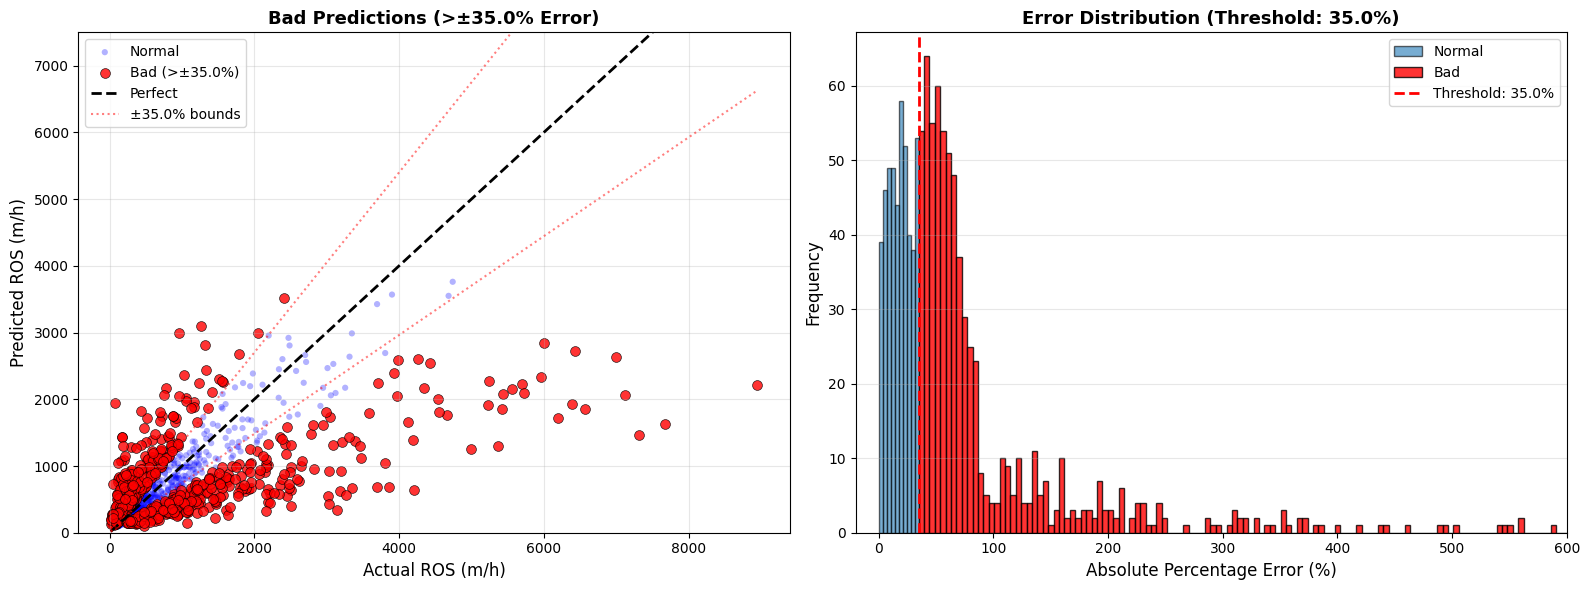

In [ ]:
# Configuration
output_path = '../../Data/Results/test_dataset_with_bad_preds.csv'
threshold = 35.0

print("=" * 80)
print("DATA VALIDATION")
print("=" * 80)
print(f"Number of test observations: {len(avg_actual_linear)}")
print(f"Number of predictions: {len(avg_pred_linear)}")

print(f"\nActual ROS statistics:")
print(f"  Min: {avg_actual_linear.min():.2f} m/h")
print(f"  Max: {avg_actual_linear.max():.2f} m/h")
print(f"  Mean: {avg_actual_linear.mean():.2f} m/h")
print(f"  Median: {np.median(avg_actual_linear):.2f} m/h")

print(f"\nPredicted ROS statistics:")
print(f"  Min: {np.min(avg_pred_linear):.2f} m/h")
print(f"  Max: {np.max(avg_pred_linear):.2f} m/h")
print(f"  Mean: {np.mean(avg_pred_linear):.2f} m/h")
print(f"  Median: {np.median(avg_pred_linear):.2f} m/h")

# Calculate Errors
residuals = avg_pred_linear - avg_actual_linear
abs_residuals = np.abs(residuals)

with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(avg_actual_linear != 0, (residuals / avg_actual_linear) * 100, 0)

percent_errors = np.abs(percent_errors_signed)

# Identify Bad Predictions
bad_pred_mask = percent_errors > threshold

print("\n" + "=" * 80)
print(f"BAD PREDICTION DETECTION: ±{threshold}% THRESHOLD METHOD")
print("=" * 80)
print(f"Bad Prediction Definition: Predictions with |error| > ±{threshold}%")
print(f"Number of bad predictions: {bad_pred_mask.sum()} ({bad_pred_mask.sum()/len(bad_pred_mask)*100:.1f}% of data)")
print(f"Number of normal observations: {(~bad_pred_mask).sum()} ({(~bad_pred_mask).sum()/len(bad_pred_mask)*100:.1f}% of data)")

# Sample Predictions
n_samples = 10
print(f"\nSample of {n_samples} random predictions:")
print(f"{'Actual':<12} {'Predicted':<12} {'% Error':<12} {'Is Bad':<12}")
print("-" * 50)

sample_indices = np.random.choice(len(avg_actual_linear), min(n_samples, len(avg_actual_linear)), replace=False)
for idx in sample_indices:
    actual = avg_actual_linear[idx]
    pred = avg_pred_linear[idx]
    pct_err = percent_errors_signed[idx]
    is_bad = bad_pred_mask[idx]
    print(f"{actual:>11.2f} {pred:>11.2f} {pct_err:>+11.2f}% {'YES' if is_bad else 'NO':<12}")

# Error Statistics
print(f"\nBad Prediction Statistics:")
if bad_pred_mask.sum() > 0:
    print(f"  Mean absolute percentage error: {percent_errors[bad_pred_mask].mean():.1f}%")
    print(f"  Median absolute percentage error: {np.median(percent_errors[bad_pred_mask]):.1f}%")
    print(f"  Max absolute percentage error: {percent_errors[bad_pred_mask].max():.1f}%")
else:
    print(f"  No bad predictions found (>±{threshold}%)")

print(f"\nNormal Predictions Statistics:")
if (~bad_pred_mask).sum() > 0:
    print(f"  Mean absolute percentage error: {percent_errors[~bad_pred_mask].mean():.1f}%")
    print(f"  Median absolute percentage error: {np.median(percent_errors[~bad_pred_mask]):.1f}%")
    print(f"  Max absolute percentage error: {percent_errors[~bad_pred_mask].max():.1f}%")

# Create Predictions DataFrame with positional indices
predictions_df = pd.DataFrame({
    'Pos_Index': indices,  # positional indices from nested CV
    'Actual_Linear': avg_actual_linear,
    'Predicted_Linear': avg_pred_linear,
    'Residual_Linear': residuals,
    'Percent_Error': percent_errors_signed,
    'Abs_Percent_Error': percent_errors,
    'Abs_Residual_Lin': abs_residuals
})

# Top Worst Predictions
n_top = 50
print("\n" + "-" * 140)
print(f"TOP {n_top} WORST PREDICTIONS (>±{threshold}% error):")
print("-" * 140)
print(f"{'Pos_Idx':<10} {'Actual(m/h)':<12} {'Pred(m/h)':<12} {'Error(m/h)':<12} {'%Error':<10} {'Abs_%Err':<12}")
print("-" * 140)

worst = predictions_df[predictions_df['Abs_Percent_Error'] > threshold].sort_values('Abs_Percent_Error', ascending=False).head(n_top)
for _, row in worst.iterrows():
    print(f"{int(row['Pos_Index']):<10} {row['Actual_Linear']:>11.1f} {row['Predicted_Linear']:>11.1f} {row['Residual_Linear']:>+11.1f} {row['Percent_Error']:>+9.1f}% {row['Abs_Percent_Error']:>11.1f}%")

# Add Predictions to DataFrame
print("\n" + "=" * 60)
print("ADDING PREDICTIONS TO DATAFRAME")
print("=" * 60)

# Reset df index to ensure positional alignment
df_updated = df.reset_index(drop=True).copy()

df_updated['bad_pred'] = np.nan
df_updated['Pred_ROS'] = np.nan
df_updated['Pred_Error'] = np.nan
df_updated['Pct_Error'] = np.nan
df_updated['AbsPctErr'] = np.nan

# Insert predictions using iloc (positional)
pos_indices = predictions_df['Pos_Index'].astype(int).values
df_updated.iloc[pos_indices, df_updated.columns.get_loc('Pred_ROS')] = predictions_df['Predicted_Linear'].values
df_updated.iloc[pos_indices, df_updated.columns.get_loc('Pred_Error')] = predictions_df['Residual_Linear'].values
df_updated.iloc[pos_indices, df_updated.columns.get_loc('Pct_Error')] = predictions_df['Percent_Error'].values
df_updated.iloc[pos_indices, df_updated.columns.get_loc('AbsPctErr')] = predictions_df['Abs_Percent_Error'].values

# Evaluate bad predictions
pred_mask = df_updated['Pred_ROS'].notna()
df_updated.loc[pred_mask, 'bad_pred'] = df_updated.loc[pred_mask, 'AbsPctErr'] > threshold

bad_pred_count = df_updated['bad_pred'].sum()
print(f"\nAdded predictions to {len(pos_indices)} observations")
print(f"Marked {int(bad_pred_count)} observations as bad predictions (>±{threshold}% error)")

# Overall Statistics
all_with_pred = df_updated[df_updated['Pred_ROS'].notna()]
bad_preds = df_updated[df_updated['bad_pred'] == True]

print("\n" + "-" * 60)
print("OVERALL STATISTICS:")
print("-" * 60)
print(f"Total observations: {len(df_updated)}")
print(f"Observations with predictions: {len(all_with_pred)} ({len(all_with_pred)/len(df_updated)*100:.2f}%)")
print(f"Number of bad predictions: {len(bad_preds)} ({len(bad_preds)/len(all_with_pred)*100:.2f}%)")

print(f"\nAll Predictions:")
print(f"  Mean Actual ROS: {all_with_pred['ros_p'].mean():.1f} m/h")
print(f"  Mean Predicted ROS: {all_with_pred['Pred_ROS'].mean():.1f} m/h")
print(f"  Mean Absolute Error: {np.abs(all_with_pred['Pred_Error']).mean():.1f} m/h")
print(f"  Mean Absolute Percentage Error: {all_with_pred['AbsPctErr'].mean():.1f}%")
print(f"  Mean Percentage Error: {all_with_pred['Pct_Error'].mean():+.1f}%")

if len(bad_preds) > 0:
    print(f"\nBad Predictions Only (>±{threshold}% error):")
    print(f"  Mean Actual ROS: {bad_preds['ros_p'].mean():.1f} m/h")
    print(f"  Mean Predicted ROS: {bad_preds['Pred_ROS'].mean():.1f} m/h")
    print(f"  Mean Absolute Error: {np.abs(bad_preds['Pred_Error']).mean():.1f} m/h")
    print(f"  Mean Absolute Percentage Error: {bad_preds['AbsPctErr'].mean():.1f}%")
    print(f"  Mean Percentage Error: {bad_preds['Pct_Error'].mean():+.1f}%")

# Prediction Bias
all_overpred = all_with_pred[all_with_pred['Pred_Error'] > 0]
all_underpred = all_with_pred[all_with_pred['Pred_Error'] < 0]
print(f"\nOverall Prediction Bias:")
print(f"  Overpredictions: {len(all_overpred)} ({len(all_overpred)/len(all_with_pred)*100:.1f}%)")
print(f"  Underpredictions: {len(all_underpred)} ({len(all_underpred)/len(all_with_pred)*100:.1f}%)")

if len(bad_preds) > 0:
    bad_overpred = bad_preds[bad_preds['Pred_Error'] > 0]
    bad_underpred = bad_preds[bad_preds['Pred_Error'] < 0]
    print(f"\nBad Prediction Bias:")
    print(f"  Overpredictions: {len(bad_overpred)} ({len(bad_overpred)/len(bad_preds)*100:.1f}%)")
    print(f"  Underpredictions: {len(bad_underpred)} ({len(bad_underpred)/len(bad_preds)*100:.1f}%)")

# Save CSV
df_to_save = df_updated.copy()
column_mapping = {'Pred_ROS': 'PredROS', 'Pred_Error': 'PredErr', 'Pct_Error': 'PctErr', 'AbsPctErr': 'AbsPctErr'}
df_to_save.rename(columns=column_mapping, inplace=True)
df_to_save.to_csv(output_path, index=False)

print(f"\n✓ CSV saved to: {output_path}")
print(f"\nNew columns: bad_pred, PredROS, PredErr, PctErr, AbsPctErr")

# Quick Access Guide
print("\n" + "=" * 60)
print("QUICK ACCESS:")
print("=" * 60)
print("All predictions: df_updated[df_updated['Pred_ROS'].notna()]")
print(f"Bad predictions: df_updated[df_updated['bad_pred'] == True]")
print("Normal predictions: df_updated[df_updated['bad_pred'] == False]")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(avg_actual_linear[~bad_pred_mask], avg_pred_linear[~bad_pred_mask], 
               alpha=0.3, s=20, c='blue', label='Normal', edgecolor='none')
axes[0].scatter(avg_actual_linear[bad_pred_mask], avg_pred_linear[bad_pred_mask], 
               alpha=0.8, s=50, c='red', label=f'Bad (>±{threshold}%)', edgecolor='black', linewidth=0.5)

min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')

x_range = np.linspace(min_val, max_val, 100)
threshold_factor = 1 + (threshold / 100)
axes[0].plot(x_range, x_range * threshold_factor, 'r:', linewidth=1.5, alpha=0.5, label=f'±{threshold}% bounds')
axes[0].plot(x_range, x_range / threshold_factor, 'r:', linewidth=1.5, alpha=0.5)

axes[0].set_xlabel('Actual ROS (m/h)', fontsize=12)
axes[0].set_ylabel('Predicted ROS (m/h)', fontsize=12)
axes[0].set_title(f'Bad Predictions (>±{threshold}% Error)', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 7500)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(percent_errors[~bad_pred_mask], bins=10, alpha=0.6, label='Normal', edgecolor='black')
axes[1].hist(percent_errors[bad_pred_mask], bins=500, alpha=0.8, color='red', label='Bad', edgecolor='black')
axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold}%')
axes[1].set_xlabel('Absolute Percentage Error (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_xlim(-20, 600)
axes[1].set_title(f'Error Distribution (Threshold: {threshold}%)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Obtain outliers

DATA VALIDATION
Number of test observations: 1173
Number of predictions: 1173

Actual ROS statistics:
  Min: 16.98 m/h
  Max: 8949.20 m/h
  Mean: 900.92 m/h
  Median: 518.15 m/h

Predicted ROS statistics:
  Min: 82.16 m/h
  Max: 3761.31 m/h
  Mean: 702.29 m/h
  Median: 508.89 m/h

OUTLIER DETECTION: 95TH PERCENTILE METHOD
Calculated 95th percentile threshold: 233.95%
Outlier Definition: Predictions with |error| > 233.95%
Number of outliers: 59 (5.0% of data)
Number of normal observations: 1114 (95.0% of data)

Sample of 10 random predictions:
Actual       Predicted    % Error      Is Outlier  
--------------------------------------------------
     140.64      232.03      +64.98% NO          
    1685.12     1123.07      -33.35% NO          
    3696.30     3426.41       -7.30% NO          
     229.19      271.02      +18.25% NO          
     133.95      596.04     +344.98% YES         
     341.45      199.50      -41.57% NO          
     305.82      231.01      -24.46% NO         

/var/folders/nd/lhjntdrn573g6k_xbhlvvzyc0000gn/T/ipykernel_27407/862602875.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ...  True False  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_updated.loc[pred_mask, 'outliers'] = df_updated.loc[pred_mask, 'AbsPctErr'] > threshold


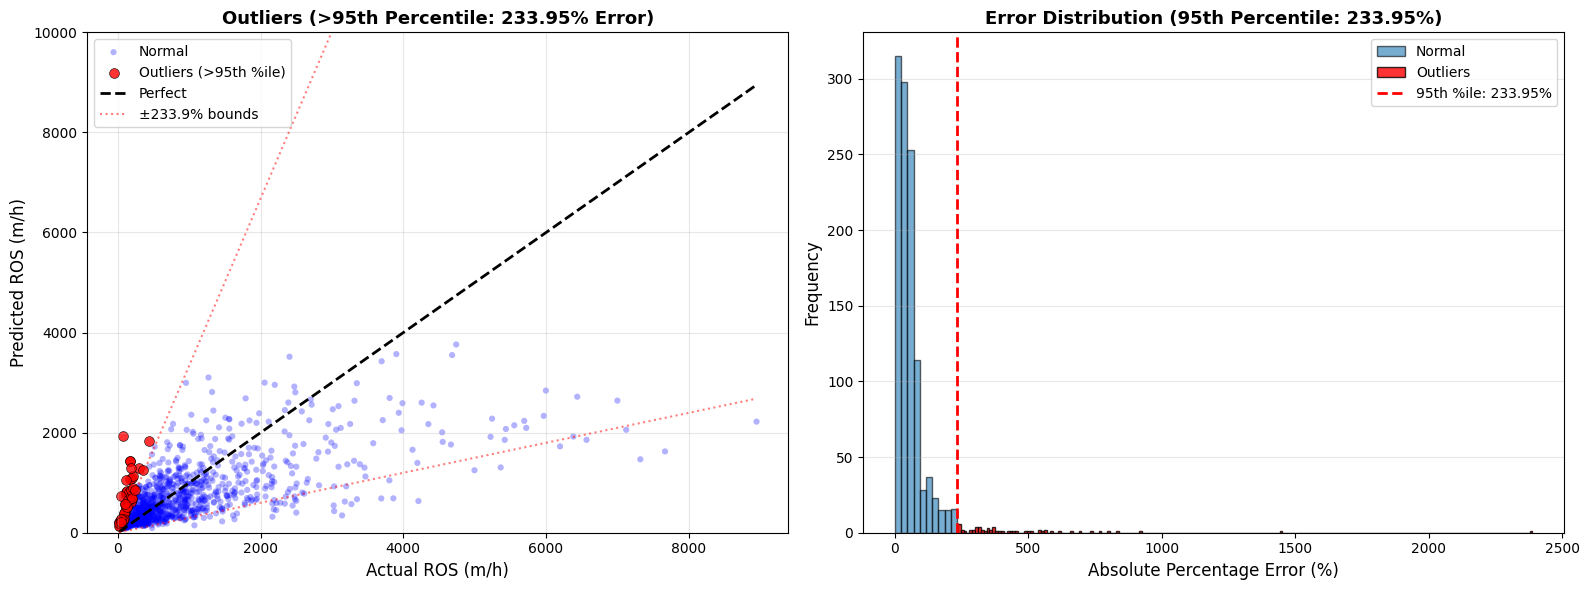

In [ ]:
# Configuration
output_path = '../../Data/Results/test_dataset_with_outliers.csv'
percentile_threshold = 95

print("=" * 80)
print("DATA VALIDATION")
print("=" * 80)
print(f"Number of test observations: {len(avg_actual_linear)}")
print(f"Number of predictions: {len(avg_pred_linear)}")

print(f"\nActual ROS statistics:")
print(f"  Min: {avg_actual_linear.min():.2f} m/h")
print(f"  Max: {avg_actual_linear.max():.2f} m/h")
print(f"  Mean: {avg_actual_linear.mean():.2f} m/h")
print(f"  Median: {np.median(avg_actual_linear):.2f} m/h")

print(f"\nPredicted ROS statistics:")
print(f"  Min: {np.min(avg_pred_linear):.2f} m/h")
print(f"  Max: {np.max(avg_pred_linear):.2f} m/h")
print(f"  Mean: {np.mean(avg_pred_linear):.2f} m/h")
print(f"  Median: {np.median(avg_pred_linear):.2f} m/h")

# Calculate Errors
residuals = avg_pred_linear - avg_actual_linear
abs_residuals = np.abs(residuals)

with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(avg_actual_linear != 0, (residuals / avg_actual_linear) * 100, 0)

percent_errors = np.abs(percent_errors_signed)

# Calculate 95th percentile threshold
threshold = np.percentile(percent_errors, percentile_threshold)

# Identify Outliers (above 95th percentile)
outlier_mask = percent_errors > threshold

print("\n" + "=" * 80)
print(f"OUTLIER DETECTION: {percentile_threshold}TH PERCENTILE METHOD")
print("=" * 80)
print(f"Calculated {percentile_threshold}th percentile threshold: {threshold:.2f}%")
print(f"Outlier Definition: Predictions with |error| > {threshold:.2f}%")
print(f"Number of outliers: {outlier_mask.sum()} ({outlier_mask.sum()/len(outlier_mask)*100:.1f}% of data)")
print(f"Number of normal observations: {(~outlier_mask).sum()} ({(~outlier_mask).sum()/len(outlier_mask)*100:.1f}% of data)")

# Sample Predictions
n_samples = 10
print(f"\nSample of {n_samples} random predictions:")
print(f"{'Actual':<12} {'Predicted':<12} {'% Error':<12} {'Is Outlier':<12}")
print("-" * 50)

sample_indices = np.random.choice(len(avg_actual_linear), min(n_samples, len(avg_actual_linear)), replace=False)
for idx in sample_indices:
    actual = avg_actual_linear[idx]
    pred = avg_pred_linear[idx]
    pct_err = percent_errors_signed[idx]
    is_outlier = outlier_mask[idx]
    print(f"{actual:>11.2f} {pred:>11.2f} {pct_err:>+11.2f}% {'YES' if is_outlier else 'NO':<12}")

# Error Statistics
print(f"\nOutlier Statistics (>{percentile_threshold}th percentile: {threshold:.2f}%):")
if outlier_mask.sum() > 0:
    print(f"  Mean absolute percentage error: {percent_errors[outlier_mask].mean():.1f}%")
    print(f"  Median absolute percentage error: {np.median(percent_errors[outlier_mask]):.1f}%")
    print(f"  Max absolute percentage error: {percent_errors[outlier_mask].max():.1f}%")
else:
    print(f"  No outliers found (>{percentile_threshold}th percentile)")

print(f"\nNormal Predictions Statistics (<={percentile_threshold}th percentile: {threshold:.2f}%):")
if (~outlier_mask).sum() > 0:
    print(f"  Mean absolute percentage error: {percent_errors[~outlier_mask].mean():.1f}%")
    print(f"  Median absolute percentage error: {np.median(percent_errors[~outlier_mask]):.1f}%")
    print(f"  Max absolute percentage error: {percent_errors[~outlier_mask].max():.1f}%")

# Create Predictions DataFrame
predictions_df = pd.DataFrame({
    'Pos_Index': indices,  # positional indices from nested CV
    'Actual_Linear': avg_actual_linear,
    'Predicted_Linear': avg_pred_linear,
    'Residual_Linear': residuals,
    'Percent_Error': percent_errors_signed,
    'Abs_Percent_Error': percent_errors,
    'Abs_Residual_Lin': abs_residuals
})

# Top Worst Predictions
n_top = 50
print("\n" + "-" * 140)
print(f"TOP {n_top} WORST PREDICTIONS (>{percentile_threshold}th percentile: {threshold:.2f}% error):")
print("-" * 140)
print(f"{'Pos_Idx':<10} {'Actual(m/h)':<12} {'Pred(m/h)':<12} {'Error(m/h)':<12} {'%Error':<10} {'Abs_%Err':<12}")
print("-" * 140)

worst = predictions_df[predictions_df['Abs_Percent_Error'] > threshold].sort_values('Abs_Percent_Error', ascending=False).head(n_top)
for _, row in worst.iterrows():
    print(f"{int(row['Pos_Index']):<10} {row['Actual_Linear']:>11.1f} {row['Predicted_Linear']:>11.1f} {row['Residual_Linear']:>+11.1f} {row['Percent_Error']:>+9.1f}% {row['Abs_Percent_Error']:>11.1f}%")

print("\n" + "=" * 60)
print("ADDING PREDICTIONS TO DATAFRAME")
print("=" * 60)

# Reset df index to ensure positional alignment
df_updated = df.reset_index(drop=True).copy()

df_updated['outliers'] = np.nan
df_updated['Pred_ROS'] = np.nan
df_updated['Pred_Error'] = np.nan
df_updated['Pct_Error'] = np.nan
df_updated['AbsPctErr'] = np.nan

# Insert predictions using iloc (positional)
pos_indices = predictions_df['Pos_Index'].astype(int).values
df_updated.iloc[pos_indices, df_updated.columns.get_loc('Pred_ROS')] = predictions_df['Predicted_Linear'].values
df_updated.iloc[pos_indices, df_updated.columns.get_loc('Pred_Error')] = predictions_df['Residual_Linear'].values
df_updated.iloc[pos_indices, df_updated.columns.get_loc('Pct_Error')] = predictions_df['Percent_Error'].values
df_updated.iloc[pos_indices, df_updated.columns.get_loc('AbsPctErr')] = predictions_df['Abs_Percent_Error'].values

print(f"\nAdded predictions to {len(pos_indices)} observations")

# Evaluate outliers (ONLY for rows with predictions)
pred_mask = df_updated['Pred_ROS'].notna()
df_updated.loc[pred_mask, 'outliers'] = df_updated.loc[pred_mask, 'AbsPctErr'] > threshold

outlier_count = df_updated['outliers'].sum()
print(f"Marked {int(outlier_count)} observations as outliers (>{percentile_threshold}th percentile: {threshold:.2f}% error)")

# Overall Statistics
all_with_pred = df_updated[df_updated['Pred_ROS'].notna()]
outliers_df = df_updated[df_updated['outliers'] == True]

print("\n" + "-" * 60)
print("OVERALL STATISTICS:")
print("-" * 60)
print(f"Total observations: {len(df_updated)}")
print(f"Observations with predictions: {len(all_with_pred)} ({len(all_with_pred)/len(df_updated)*100:.2f}%)")
print(f"Number of outliers: {len(outliers_df)} ({len(outliers_df)/len(all_with_pred)*100:.2f}%)")

print(f"\nAll Predictions:")
print(f"  Mean Actual ROS: {all_with_pred['ros_p'].mean():.1f} m/h")
print(f"  Mean Predicted ROS: {all_with_pred['Pred_ROS'].mean():.1f} m/h")
print(f"  Mean Absolute Error: {np.abs(all_with_pred['Pred_Error']).mean():.1f} m/h")
print(f"  Mean Absolute Percentage Error: {all_with_pred['AbsPctErr'].mean():.1f}%")
print(f"  Mean Percentage Error: {all_with_pred['Pct_Error'].mean():+.1f}%")

if len(outliers_df) > 0:
    print(f"\nOutliers Only (>{percentile_threshold}th percentile: {threshold:.2f}% error):")
    print(f"  Mean Actual ROS: {outliers_df['ros_p'].mean():.1f} m/h")
    print(f"  Mean Predicted ROS: {outliers_df['Pred_ROS'].mean():.1f} m/h")
    print(f"  Mean Absolute Error: {np.abs(outliers_df['Pred_Error']).mean():.1f} m/h")
    print(f"  Mean Absolute Percentage Error: {outliers_df['AbsPctErr'].mean():.1f}%")
    print(f"  Mean Percentage Error: {outliers_df['Pct_Error'].mean():+.1f}%")

# Prediction Bias
all_overpred = all_with_pred[all_with_pred['Pred_Error'] > 0]
all_underpred = all_with_pred[all_with_pred['Pred_Error'] < 0]
print(f"\nOverall Prediction Bias:")
print(f"  Overpredictions: {len(all_overpred)} ({len(all_overpred)/len(all_with_pred)*100:.1f}%)")
print(f"  Underpredictions: {len(all_underpred)} ({len(all_underpred)/len(all_with_pred)*100:.1f}%)")

if len(outliers_df) > 0:
    outlier_overpred = outliers_df[outliers_df['Pred_Error'] > 0]
    outlier_underpred = outliers_df[outliers_df['Pred_Error'] < 0]
    print(f"\nOutlier Prediction Bias:")
    print(f"  Overpredictions: {len(outlier_overpred)} ({len(outlier_overpred)/len(outliers_df)*100:.1f}%)")
    print(f"  Underpredictions: {len(outlier_underpred)} ({len(outlier_underpred)/len(outliers_df)*100:.1f}%)")

# Save CSV
df_to_save = df_updated.copy()
column_mapping = {'Pred_ROS': 'PredROS', 'Pred_Error': 'PredErr', 'Pct_Error': 'PctErr', 'AbsPctErr': 'AbsPctErr'}
df_to_save.rename(columns=column_mapping, inplace=True)
df_to_save.to_csv(output_path, index=False)

print(f"\n✓ CSV saved to: {output_path}")
print(f"\nNew columns: outliers, PredROS, PredErr, PctErr, AbsPctErr")

# Quick Access Guide
print("\n" + "=" * 60)
print("QUICK ACCESS:")
print("=" * 60)
print("All predictions: df_updated[df_updated['Pred_ROS'].notna()]")
print(f"Outliers: df_updated[df_updated['outliers'] == True]")
print("Normal predictions: df_updated[df_updated['outliers'] == False]")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(avg_actual_linear[~outlier_mask], avg_pred_linear[~outlier_mask], 
               alpha=0.3, s=20, c='blue', label='Normal', edgecolor='none')
axes[0].scatter(avg_actual_linear[outlier_mask], avg_pred_linear[outlier_mask], 
               alpha=0.8, s=50, c='red', label=f'Outliers (>{percentile_threshold}th %ile)', edgecolor='black', linewidth=0.5)

min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')

x_range = np.linspace(min_val, max_val, 100)
threshold_factor = 1 + (threshold / 100)
axes[0].plot(x_range, x_range * threshold_factor, 'r:', linewidth=1.5, alpha=0.5, label=f'±{threshold:.1f}% bounds')
axes[0].plot(x_range, x_range / threshold_factor, 'r:', linewidth=1.5, alpha=0.5)

axes[0].set_xlabel('Actual ROS (m/h)', fontsize=12)
axes[0].set_ylabel('Predicted ROS (m/h)', fontsize=12)
axes[0].set_title(f'Outliers (>{percentile_threshold}th Percentile: {threshold:.2f}% Error)', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 10000)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(percent_errors[~outlier_mask], bins=10, alpha=0.6, label='Normal', edgecolor='black')
axes[1].hist(percent_errors[outlier_mask], bins=200, alpha=0.8, color='red', label='Outliers', edgecolor='black')
axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'{percentile_threshold}th %ile: {threshold:.2f}%')
axes[1].set_xlabel('Absolute Percentage Error (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Error Distribution ({percentile_threshold}th Percentile: {threshold:.2f}%)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
sample_df = pd.DataFrame({
    'Actual ROS (log)': avg_actual,
    'Predicted ROS (log)': avg_pred,
    'Actual ROS (linear)': avg_actual_linear,
    'Predicted ROS (linear)': avg_pred_linear
})

# Randomly sample 20 rows
sample_20 = sample_df.sample(20).copy()

# Compute % error (using linear values)
sample_20['% Error'] = ((sample_20['Predicted ROS (linear)'] - sample_20['Actual ROS (linear)']) / sample_20['Actual ROS (linear)']) * 100

print("Sample of 20 predictions vs actual ROS values:\n")
display(sample_20)

Sample of 20 predictions vs actual ROS values:



,Actual ROS (log),Predicted ROS (log),Actual ROS (linear),Predicted ROS (linear),% Error
4,14.254216,15.737120,708.321556,1403.183724,98.099820
1076,16.251075,13.877349,1778.159916,595.306825,-66.521187
828,14.799418,14.635588,910.766540,844.507644,-7.275069
998,14.702559,16.208738,870.990553,1743.808087,100.209759
753,13.888589,11.946962,598.401578,244.127746,-59.203359
996,14.229427,16.115774,700.270197,1670.686483,138.577408
984,16.891961,17.077147,2388.968816,2601.731127,8.906031
1049,9.685626,11.829223,85.521724,231.190548,170.329615
656,15.212924,13.075964,1102.023420,411.280501,-62.679514
944,14.429984,12.708166,768.124723,347.043257,-54.819413


### SHAP

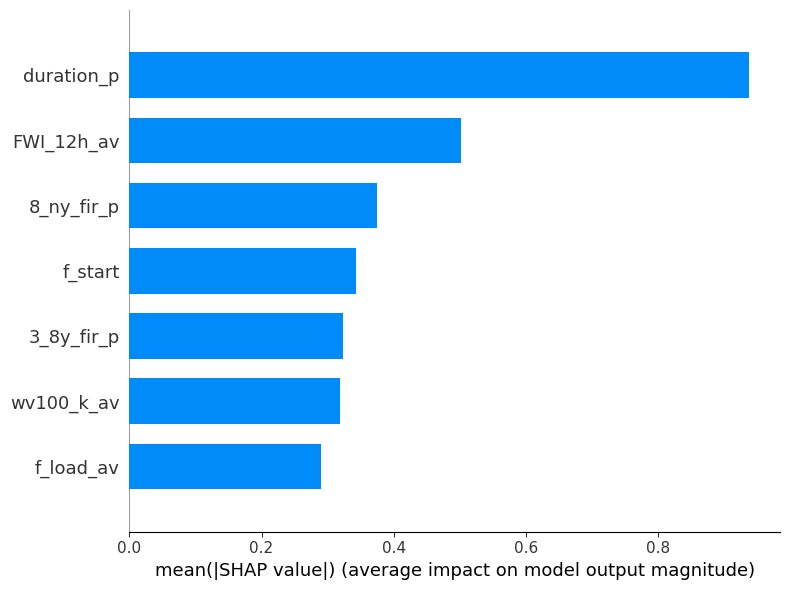

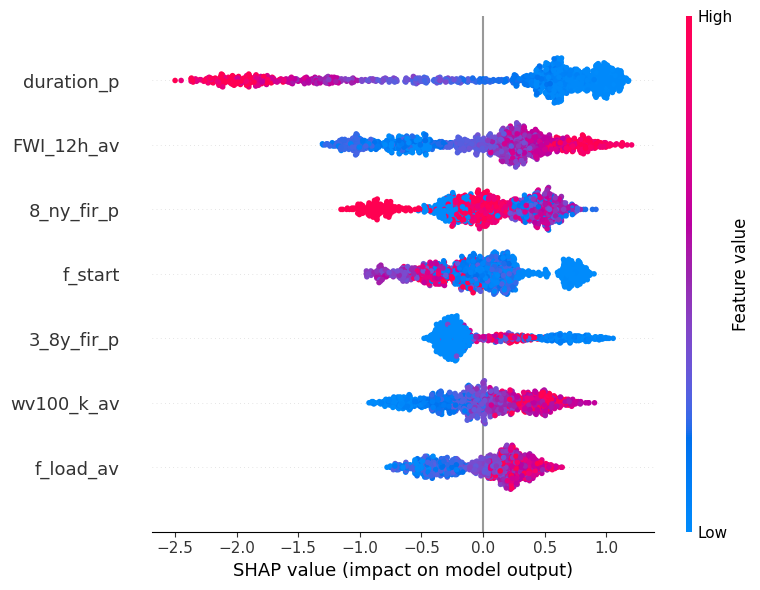


Mean |SHAP| for top 20 variables:
duration_p    0.937691
FWI_12h_av    0.502242
8_ny_fir_p    0.374282
f_start       0.342963
3_8y_fir_p    0.323580
wv100_k_av    0.319233
f_load_av     0.289358
dtype: float32

✓ Saved to: ../../Data/Results/dataset_with_SHAP.csv
Added 7 SHAP columns


In [ ]:
# Calculate SHAP values using full dataset X
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)
shap_values_abs = np.abs(shap_values)

# Plots
shap.summary_plot(shap_values, X, plot_type="bar", plot_size=(8, 6))
shap.summary_plot(shap_values, X, plot_size=(8, 6))

# List top 20 variables by mean |SHAP| value
mean_SHAP_values = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=X.columns
).sort_values(ascending=False)

print("\nMean |SHAP| for top 20 variables:")
print(mean_SHAP_values.head(20))

# Create SHAP dataframe - use default index (0 to len-1)
shap_columns = pd.DataFrame(
    shap_values,
    columns=[f'SHAP_{col}' for col in X.columns],
    )  # Removed index=X.index - X.index is non-contiguous after dropna

# Reset df index to match (both now 0 to len-1)
df_reset = df.reset_index(drop=True)

# Combine - indices now align correctly
df_with_shap = pd.concat([df_reset, shap_columns], axis=1)

df_with_shap.to_csv('../../Data/Results/dataset_with_SHAP.csv', index=False)

print(f"\n✓ Saved to: ../../Data/Results/dataset_with_SHAP.csv")
print(f"Added {len(shap_columns.columns)} SHAP columns")

### Merge the outlier and SHAP dataframes into 1 and delete them

In [ ]:
import pandas as pd

# File paths
shap_path = r'../../Data/Results/test_dataset_with_SHAP.csv'
outliers_path = r'../../Data/Results/test_dataset_with_outliers.csv'
bad_preds_path = r'../../Data/Results/test_dataset_with_bad_preds.csv'
output_path = r'../../Data/Results/test_dataset_merged.csv'

# Load CSVs
shap_df = pd.read_csv(shap_path)
outliers_df = pd.read_csv(outliers_path)
bad_preds_df = pd.read_csv(bad_preds_path)

# Definir coluna de chave para merge
key_col = 'row_id'  # ou 'CV_Index', se for o caso

# Selecionar apenas as colunas relevantes de cada CSV
shap_cols = [c for c in shap_df.columns if c.startswith('SHAP_')] + [key_col]
outlier_cols = ['ros_p', 'outliers', 'PredROS', 'PredErr', 'PctErr', 'AbsPctErr', key_col]
bad_pred_cols = ['bad_pred', key_col]

# Subconjuntos
shap_subset = shap_df[shap_cols]
outlier_subset = outliers_df[outlier_cols]
bad_pred_subset = bad_preds_df[bad_pred_cols]

# Merge passo a passo pelo identificador
merged = shap_subset.merge(outlier_subset, on=key_col, how='left')
merged = merged.merge(bad_pred_subset, on=key_col, how='left')

# Ordenar
merged = merged.sort_values('PredROS')
# KEEP row_id for shapefile merge!
# merged = merged.drop(columns=[key_col])  # REMOVED - need row_id for shapefile merge

# Salvar
merged.to_csv(output_path, index=False)
print(f"Saved: {output_path}")
print(f"Total columns: {len(merged.columns)}")
print(f"\nColumns: {list(merged.columns)}")


'''for path in [shap_path, outliers_path, bad_preds_path]:
    base = path.rsplit('.', 1)[0]
    for f in glob.glob(f"{base}.*"):
        os.remove(f)
        print(f"Deleted: {f}")'''

Saved: ../../Data/Results/test_dataset_merged.csv
Total columns: 15

Columns: ['SHAP_duration_p', 'SHAP_8_ny_fir_p', 'SHAP_3_8y_fir_p', 'SHAP_f_load_av', 'SHAP_sW_100_av', 'SHAP_f_start', 'SHAP_FWI_12h_av', 'row_id', 'ros_p', 'outliers', 'PredROS', 'PredErr', 'PctErr', 'AbsPctErr', 'bad_pred']


'for path in [shap_path, outliers_path, bad_preds_path]:\n    base = path.rsplit(\'.\', 1)[0]\n    for f in glob.glob(f"{base}.*"):\n        os.remove(f)\n        print(f"Deleted: {f}")'

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np

# -------------------------------
# 1️⃣ Configurações
# -------------------------------
csv_path = r'../../Data/Results/test_dataset_merged.csv'
shapefile_path = r'../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final.shp'
output_shapefile = r'../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.shp'

# -------------------------------
# 2️⃣ Carregar arquivos
# -------------------------------
merged_df = pd.read_csv(csv_path)
gdf = gpd.read_file(shapefile_path)

print(f"CSV: {len(merged_df)} linhas")
print(f"Shapefile: {len(gdf)} linhas")

# -------------------------------
# 3️⃣ FIX: Add row_id to shapefile if missing
# -------------------------------
if 'row_id' not in gdf.columns:
    gdf['row_id'] = range(len(gdf))
    print("Added row_id to shapefile")

# -------------------------------
# 4️⃣ Merge by row_id (not ros_p!)
# -------------------------------
# Drop geometry temporarily for merge
gdf_no_geom = gdf.drop(columns='geometry')

# Merge CSV data onto shapefile using row_id
merged_gdf = gdf_no_geom.merge(
    merged_df, 
    on='row_id', 
    how='left',
    suffixes=('', '_csv')
)

# Handle duplicate columns (keep CSV version where available)
for col in merged_df.columns:
    if col != 'row_id' and f'{col}_csv' in merged_gdf.columns:
        merged_gdf[col] = merged_gdf[f'{col}_csv'].fillna(merged_gdf[col])
        merged_gdf.drop(columns=f'{col}_csv', inplace=True)

# Add geometry back
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry=gdf.geometry, crs=gdf.crs)

# Check how many got predictions
n_with_pred = merged_gdf['PredROS'].notna().sum() if 'PredROS' in merged_gdf.columns else 0
print(f"Rows with predictions: {n_with_pred}")

# -------------------------------
# 5️⃣ Exportar shapefile
# -------------------------------
merged_gdf.to_file(output_shapefile)
print(f"✓ GeoDataFrame salvo com geometria em: {output_shapefile}")

# Exportar CSV também
csv_output_path = output_shapefile.replace('.shp', '.csv')
merged_gdf.drop(columns='geometry').to_csv(csv_output_path, index=False)
print(f"✓ CSV salvo sem geometria em: {csv_output_path}")


CSV: 1173 linhas
Shapefile: 3355 linhas
Added row_id to shapefile
Rows with predictions: 1173


/var/folders/nd/lhjntdrn573g6k_xbhlvvzyc0000gn/T/ipykernel_27407/2292166399.py:58: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file(output_shapefile)
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAP_duration_p' to 'SHAP_durat'
  ogr_write(
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAP_8_ny_fir_p' to 'SHAP_8_ny_'
  ogr_write(
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAP_3_8y_fir_p' to 'SHAP_3_8y_'
  ogr_write(
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAP_f_load_av' to 'SHAP_f_loa'
  ogr_write(
/opt/anaconda3/envs/RAG/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/lau

✓ GeoDataFrame salvo com geometria em: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.shp
✓ CSV salvo sem geometria em: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.csv


### Plot of nº inputs vs Model accuracy

In [ ]:
"""
Progressive feature reduction analysis for XGBoost model.
Trains the model with decreasing numbers of features based on importance ranking.

NOTA: este codigo necessita que o modelo seja treinado com todas as features, e 
que no dicionario 'feature_ranking' estejam as features ordenadas por importancia.
"""

"""# Feature importance ranking (from your list)
features = [
    "duration_p",
    "8_ny_fir_p",
    "3_8y_fir_p",
    "f_load_av",
    "sW_100_av",
    "f_start",
    "FWI_12h_av",
    "wv100_k_av",
    "aspect_av",
    "HDW_av",
    "rh_950_av",
    "1_3y_fir_p",
    "landform",
    "DC_12h_av",
    "gT_s_9_av",
    "wdi_950_av",
    "sW_3m_av",
    "Cape_av",
    "wv_850_av",
    "LowCC_p_av",
]


param_dist = {
    'max_depth': [2, 3],                              # ← Reduced from [3, 4, 5]
    'learning_rate': uniform(0.08, 0.22),             
    'subsample': uniform(0.5, 0.20),                  
    'colsample_bytree': uniform(0.5, 0.20),           
    'colsample_bylevel': uniform(0.5, 0.20),          
    'colsample_bynode': uniform(0.5, 0.20),           
    'min_child_weight': randint(50, 100),             # ← Increased from (25, 50)
    'gamma': uniform(3, 3),                           # ← Increased from (1.5, 2.0) → 3-6
    'reg_alpha': uniform(2, 3),                       
    'reg_lambda': uniform(6, 4),                      
    'max_delta_step': randint(0, 5),
}


base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Log transformation parameters
log_mult = 5
log_base = 10
inv_mult = np.log(log_base) / log_mult


print(f"Starting progressive feature reduction analysis...")
print(f"Total features to analyze: {len(feature_ranking)}")

# Storage for results
results = []

# Loop through different numbers of features (from all features down to 1)
for n_features in range(len(feature_ranking), 0, -1):
    print(f"\n{'='*80}")
    print(f"TRAINING WITH TOP {n_features} FEATURES")
    print(f"{'='*80}")
    
    # Select top n features
    selected_features = feature_ranking[:n_features]
    X_subset = X[selected_features].copy()
    
    print(f"Features used: {selected_features}")
    
    # Storage for fold results
    fold_r2_test = []
    fold_r2_train = []
    fold_rmse_log = []
    fold_rmse_linear = []
    
    # Cross-validation loop
    fold = 1
    for train_index, test_index in kf.split(X_subset, y):
        print(f"\n  Processing Fold {fold}...")
        
        # Split data
        X_train, X_test = X_subset.iloc[train_index], X_subset.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Log transform
        y_train_log = log_mult * np.log1p(y_train) / np.log(log_base)
        y_test_log = log_mult * np.log1p(y_test) / np.log(log_base)
        
        # Hyperparameter search
        xgb_random = HalvingRandomSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        factor=3,
        resource='n_estimators',
        max_resources=100,                              
        min_resources=20,                             
        scoring='r2',
        cv=kf,
        n_jobs=-1,
        random_state=42,
        return_train_score=True, 
        verbose=1
    )
    
        
        xgb_random.fit(
            X_train,
            y_train_log,
            eval_set=[(X_test, y_test_log)]
        )
        
        best_model = xgb_random.best_estimator_
        
        # Predictions
        y_train_pred_log = best_model.predict(X_train)
        y_test_pred_log = best_model.predict(X_test)
        
        # Inverse transform
        y_test_linear = np.exp(y_test_log * inv_mult) - 1
        y_test_pred_linear = np.exp(y_test_pred_log * inv_mult) - 1
        
        # Metrics
        r2_train = r2_score(y_train_log, y_train_pred_log)
        r2_test = r2_score(y_test_log, y_test_pred_log)
        rmse_log = np.sqrt(mean_squared_error(y_test_log, y_test_pred_log))
        rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_test_pred_linear))
        
        fold_r2_train.append(r2_train)
        fold_r2_test.append(r2_test)
        fold_rmse_log.append(rmse_log)
        fold_rmse_linear.append(rmse_linear)
        
        print(f"    Train R²: {r2_train:.4f}, Test R²: {r2_test:.4f}, RMSE: {rmse_log:.4f}")
        
        fold += 1
    
    # Average results across folds
    avg_r2_train = np.mean(fold_r2_train)
    avg_r2_test = np.mean(fold_r2_test)
    avg_rmse_log = np.mean(fold_rmse_log)
    avg_rmse_linear = np.mean(fold_rmse_linear)
    
    std_r2_test = np.std(fold_r2_test)
    std_rmse_log = np.std(fold_rmse_log)
    
    results.append({
        'n_features': n_features,
        'r2_train': avg_r2_train,
        'r2_test': avg_r2_test,
        'r2_std': std_r2_test,
        'rmse_log': avg_rmse_log,
        'rmse_log_std': std_rmse_log,
        'rmse_linear': avg_rmse_linear,
        'overfitting_gap': avg_r2_train - avg_r2_test
    })
    
    print(f"\n  AVERAGE RESULTS FOR {n_features} FEATURES:")
    print(f"    Train R²: {avg_r2_train:.4f}")
    print(f"    Test R²:  {avg_r2_test:.4f} ± {std_r2_test:.4f}")
    print(f"    Gap:      {avg_r2_train - avg_r2_test:.4f}")
    print(f"    RMSE:     {avg_rmse_log:.4f} ± {std_rmse_log:.4f} (linear: {avg_rmse_linear:.1f})")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print(f"\n{'='*80}")
print("COMPLETE RESULTS TABLE")
print(f"{'='*80}")
print(results_df.to_string(index=False))

# Create the dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot R² on left axis
color1 = 'tab:blue'
ax1.set_xlabel('Number of Input Features', fontsize=13, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=13, fontweight='bold', color=color1)
ax1.plot(results_df['n_features'], results_df['r2_test'], 
         marker='o', linewidth=2.5, markersize=8, color=color1, label='Test R²')
ax1.fill_between(results_df['n_features'], 
                  results_df['r2_test'] - results_df['r2_std'],
                  results_df['r2_test'] + results_df['r2_std'],
                  alpha=0.2, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(bottom=0)

# Plot RMSE on right axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('RMSE (log scale)', fontsize=13, fontweight='bold', color=color2)
ax2.plot(results_df['n_features'], results_df['rmse_log'], 
         marker='s', linewidth=2.5, markersize=8, color=color2, label='RMSE (log)')
ax2.fill_between(results_df['n_features'], 
                  results_df['rmse_log'] - results_df['rmse_log_std'],
                  results_df['rmse_log'] + results_df['rmse_log_std'],
                  alpha=0.2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Model Performance vs Number of Input Features\n(XGBoost with 5-Fold CV)', 
          fontsize=15, fontweight='bold', pad=20)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=11)

# Add annotation for optimal point
best_idx = results_df['r2_test'].idxmax()
best_n = results_df.loc[best_idx, 'n_features']
best_r2 = results_df.loc[best_idx, 'r2_test']
best_rmse = results_df.loc[best_idx, 'rmse_log']

ax1.annotate(f'Best: {int(best_n)} features\nR²={best_r2:.3f}',
             xy=(best_n, best_r2), xytext=(best_n-3, best_r2-0.05),
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2),
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional plot: Overfitting gap
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_features'], results_df['overfitting_gap'], 
         marker='o', linewidth=2.5, markersize=8, color='purple')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('Number of Input Features', fontsize=13, fontweight='bold')
plt.ylabel('Overfitting Gap (Train R² - Test R²)', fontsize=13, fontweight='bold')
plt.title('Model Overfitting vs Number of Features', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"\nOptimal number of features: {int(best_n)}")
print(f"Best Test R²: {best_r2:.4f}")
print(f"Best RMSE (log): {best_rmse:.4f}")
print(f"Best RMSE (linear): {results_df.loc[best_idx, 'rmse_linear']:.1f}")"""

'# Feature importance ranking (from your list)\nfeatures = [\n    "duration_p",\n    "8_ny_fir_p",\n    "3_8y_fir_p",\n    "f_load_av",\n    "sW_100_av",\n    "f_start",\n    "FWI_12h_av",\n    "wv100_k_av",\n    "aspect_av",\n    "HDW_av",\n    "rh_950_av",\n    "1_3y_fir_p",\n    "landform",\n    "DC_12h_av",\n    "gT_s_9_av",\n    "wdi_950_av",\n    "sW_3m_av",\n    "Cape_av",\n    "wv_850_av",\n    "LowCC_p_av",\n]\n\n\nparam_dist = {\n    \'max_depth\': [2, 3],                              # ← Reduced from [3, 4, 5]\n    \'learning_rate\': uniform(0.08, 0.22),             \n    \'subsample\': uniform(0.5, 0.20),                  \n    \'colsample_bytree\': uniform(0.5, 0.20),           \n    \'colsample_bylevel\': uniform(0.5, 0.20),          \n    \'colsample_bynode\': uniform(0.5, 0.20),           \n    \'min_child_weight\': randint(50, 100),             # ← Increased from (25, 50)\n    \'gamma\': uniform(3, 3),                           # ← Increased from (1.5, 2.0) → 3-6\n    

In [ ]:
"""
This code is used to perform a grid search over different logarithmic transformations
of the target variable to find the optimal parameters that yield the best model performance.
"""
"""param_dist = {
    'max_depth': [5, 7, 9, 11, 13, 15],               # tree depth
    'learning_rate': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)
    'subsample': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)
    'colsample_bylevel': uniform(0.6, 0.4),           # column sampling per level (adds complexity)
    'colsample_bynode': uniform(0.6, 0.4),            # column sampling per node (adds complexity)
    'min_child_weight': randint(1, 10),               # minimum sum of instance weight in a child
    'gamma': uniform(0, 0.5),                         # minimum loss reduction for split
    'reg_alpha': uniform(0, 1),                       # L1 regularization
    'reg_lambda': uniform(1, 3),                      # L2 regularization (increased range)
    'max_delta_step': randint(0, 5),                  # maximum delta step (helps with imbalanced data)
}


base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',                               
    enable_categorical=True                           # handle categorical features
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,                                         # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=3000,                            
    min_resources=300,                           
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Simple grid search with your actual model
log_mult_values = [0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0]
log_base_values = [2, 2.718, 5, 10]

best_score = -np.inf
best_mult = None
best_base = None
all_results = []

print("Grid search for optimal log transformation")
print("=" * 70)
print(f"Testing {len(log_mult_values)} × {len(log_base_values)} = {len(log_mult_values) * len(log_base_values)} combinations")
print("=" * 70)

for i, log_mult in enumerate(log_mult_values):
    for j, log_base in enumerate(log_base_values):
        combo_num = i * len(log_base_values) + j + 1
        total_combos = len(log_mult_values) * len(log_base_values)
        
        print(f"\n[{combo_num}/{total_combos}] Testing mult={log_mult:.2f}, base={log_base:.2f}...")
        
        # Apply transformation
        y_val_log = log_mult * np.log1p(y) / np.log(log_base)
        
        # Train with your actual hyperparameter search
        xgb_random.fit(X, y_val_log)
        
        # Get CV score
        cv_score = xgb_random.best_score_
        
        all_results.append({
            'log_mult': log_mult,
            'log_base': log_base,
            'cv_r2': cv_score
        })
        
        print(f"   Result: R² = {cv_score:.6f}")
        
        # Update best
        if cv_score > best_score:
            best_score = cv_score
            best_mult = log_mult
            best_base = log_base
            print(f"   ✓ NEW BEST!")

print("\n" + "=" * 70)
print("ALL RESULTS (sorted by R²):")
print("=" * 70)
import pandas as pd
results_df = pd.DataFrame(all_results).sort_values('cv_r2', ascending=False)
print(results_df.to_string(index=False))

print("\n" + "=" * 70)
print("FINAL RESULTS")
print("=" * 70)
print(f"Best log_mult: {best_mult}")
print(f"Best log_base: {best_base}")
print(f"Best CV R²: {best_score:.6f}")

# Retrain with best parameters
print("\nRetraining final model with best parameters...")
y_val_log_final = best_mult * np.log1p(y) / np.log(best_base)
xgb_random.fit(X, y_val_log_final)
final_model = xgb_random.best_estimator_


print("\n" + "=" * 70)
print("USE THESE FOR PREDICTIONS:")
print(f"log_mult = {best_mult}")
print(f"log_base = {best_base}")
print("=" * 70)"""

'param_dist = {\n    \'max_depth\': [5, 7, 9, 11, 13, 15],               # tree depth\n    \'learning_rate\': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)\n    \'subsample\': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)\n    \'colsample_bytree\': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)\n    \'colsample_bylevel\': uniform(0.6, 0.4),           # column sampling per level (adds complexity)\n    \'colsample_bynode\': uniform(0.6, 0.4),            # column sampling per node (adds complexity)\n    \'min_child_weight\': randint(1, 10),               # minimum sum of instance weight in a child\n    \'gamma\': uniform(0, 0.5),                         # minimum loss reduction for split\n    \'reg_alpha\': uniform(0, 1),                       # L1 regularization\n    \'reg_lambda\': uniform(1, 3),                      # L2 regularization (increased range)\n    \'max_delta_step\': randint(0, 5),                  # maximum delta 